# Executive Summary

Goal: Using a synthetic dataset based on the National Cancer Registration and Analysis Service (NCRAS) in the UK, the goal is to accurately classify whether lung cancer patients' survived or did not survive using independent variables such as patient demographics, cancer stage, grade, histology etc., and the treatment (drugs) received. 

Metrics: 
- Accuracy: achieve a score above the baseline accuracy
- Precision: reducing the rate of false positives ie. predicting a patient will survive when they did not. Therefore, optimize the precision score, however maintain a recall score >0.1

Findings:
- The baseline accuracy was 0.70
- Logistic regression, KNN, random forest, decision tree, and XGBoost models were used on unbalanced data and then on balanced data using SMOTE.
- Overall the XGBoost model (on balanced) was the most appropriate model and after tuning the model with grid search, gave an accuracy score of 0.81, indicating the model accurately predicted 81% of true positive and true negative predictions.
- A threshold/cutoff value of 0.7 gave the optimal precision score (0.7) while maintaining a recall score of >0.1. 
-  Some key features were early stage (survived) vs late stage (not survived), the drugs ifamurtide, trastuzumab, enzalutamide, and vinflunine (survived) and etoposide, carboplatin, capmatinib, and gemtuzumab ozogamycin (not survived), and mixed white and black african ethnicity (not survived).

Limitations:
- The target variable did have a class imbalance (70:30); 
- There was an assumption that the features did not have multi-colinearity; 
- There may have been features included in the analysis that were not relevant, specifically the drug variables (high number and certain drugs may have been received by very few patients)
- The feature importances may not accurately represent what features impacted which class

Future work: 
 - Using a grid search to tune a decision tree model and visualize the tree to better determine the features involved in the decision and what class is impacted
 - Grouping the individual drugs under drug classes or mechanism of action
 - Explore different cancer types and determine if other predictors/ drugs are more/less important (started looking at breast cancer)


In [1]:
import pandas as pd
from pandas.io import sql
import sqlite3
import numpy as np

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
conn = sqlite3.connect('simu.db.sqlite')

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [2]:
from xgboost import XGBClassifier

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from imblearn.over_sampling import SMOTE
# from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix ,accuracy_score, f1_score ,recall_score ,roc_auc_score, average_precision_score, precision_score ,plot_roc_curve, plot_precision_recall_curve

# Data wrangling

- Data was collected from https://healthdatainsight.org.uk/project/the-simulacrum/ 
- The data was retreived in the form of a relational database containing 8 datasets with 0.5 - > 2 million rows in each dataset
- After opening a connection to a local SQLite database, the relevant datasets were added and using SQL I retrieved the relevant data to compile into one dataset to work with  

In [4]:
#read in csv files 
pts_1 = pd.read_csv('../../../../../simulacrum_release_v1.2.0.2017/data/sim_av_patient.csv')
pts_2 = pd.read_csv('../../../../../simulacrum_release_v1.2.0.2017/data/sim_sact_patient.csv', low_memory=False)
tum_1 = pd.read_csv('../../../../../simulacrum_release_v1.2.0.2017/data/sim_av_tumour.csv', low_memory=False)
drug = pd.read_csv('../../../../../simulacrum_release_v1.2.0.2017/data/sim_sact_drug_detail.csv',low_memory=False)
regimen = pd.read_csv('../../../../../simulacrum_release_v1.2.0.2017/data/sim_sact_regimen.csv',low_memory=False)

In [ ]:
#add the csv files to SQLite database
pts_1.to_sql(name = 'pts_1', con = conn, if_exists = 'replace', index = False)
pts_2.to_sql(name = 'pts_2', con = conn, if_exists = 'replace', index = False)
tum_1.to_sql(name = 'tum_1', con = conn, if_exists = 'replace', index = False)
drug.to_sql(name = 'drug', con = conn, if_exists = 'replace', index = False)
regimen.to_sql(name = 'regimen', con = conn, if_exists = 'replace', index = False)

In [5]:
#look at data in pts_1 dataset 
df = pd.read_sql('SELECT * FROM pts_1 LIMIT 10', con=conn)
df

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,1,810000001,Z,None,None,None,None,None,None,A,2019-02-08
1,10000002,1,810000002,A,I259,None,None,I509,I259,4,A,2019-02-08
2,10000003,1,810000003,Z,None,None,None,None,None,None,A,2019-02-08
3,10000004,2,810000004,A,None,None,None,None,None,None,D,2018-01-06
4,10000005,1,810000005,A,None,None,None,None,None,None,A,2019-02-06
5,10000006,2,810000006,None,None,None,None,None,None,None,A,2019-02-08
6,10000007,1,810000007,A,None,None,None,None,None,None,A,2019-02-09
7,10000008,1,810000008,A,None,None,None,None,None,None,A,2019-02-11
8,10000009,1,810000009,A,None,None,None,None,None,None,A,2019-02-09
9,10000010,1,810000010,A,None,None,None,None,None,None,A,2019-02-06


- pts_1 dataset contains patient demographic info (sex, ethnic) and the target variable - survival status ('newvitalstatus')

In [6]:
#create function to create a df from SQLite datasets
def d(stg, connection=conn):
    df = pd.read_sql(stg, connection)
    return df

In [7]:
#look at data in tum_1
tum_df = d('SELECT * FROM tum_1 LIMIT 10')

In [8]:
tum_df

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015
0,10000001,10000001,2017-04-24,C447,C44,8070,3,1,None,None,...,None,None,None,None,None,None,None,2017-04-24,R,4
1,10000002,10000002,2016-10-18,C449,C44,8090,3,None,None,None,...,None,None,None,None,None,None,None,2018-05-14,9,2
2,10000003,10000003,2017-01-13,C447,C44,8070,3,None,None,None,...,None,None,None,None,None,None,None,2017-01-13,R,1 - least deprived
3,10000004,10000004,2015-10-28,C449,C44,8090,3,None,None,None,...,None,None,None,None,None,None,None,2016-01-08,9,1 - least deprived
4,10000005,10000005,2017-10-03,C449,C44,8090,3,None,None,None,...,None,None,None,None,None,None,None,None,9,1 - least deprived
5,10000006,10000006,2015-06-04,C440,C44,8090,3,None,None,None,...,None,None,None,None,None,None,None,2015-06-04,9,5 - most deprived
6,10000007,10000007,2014-02-13,C449,C44,8090,3,None,None,None,...,None,None,None,None,None,None,None,None,9,2
7,10000008,10000008,2015-01-27,C449,C44,8090,3,None,None,None,...,None,None,None,None,None,None,None,None,9,1 - least deprived
8,10000009,10000009,2016-06-23,C449,C44,8090,3,None,None,None,...,0,None,9,None,None,None,None,2016-06-23,9,4
9,10000010,10000010,2014-12-05,C443,C44,8090,3,None,None,None,...,None,None,None,None,None,None,None,2014-12-05,L,3


- Tum_1 dataset contains data on type of cancer (SITE_ICD10_O2), and cancer details

In [9]:
#select lung cancer rows from tum 1
#join lung cancer data from tum_1 with pts_1 to combine patients' survival status
lung_df = d("SELECT * FROM tum_1 "
        "LEFT JOIN pts_1 on tum_1.PATIENTID = pts_1.PATIENTID "
        "WHERE SITE_ICD10_O2 = 'C341' " 
         "or SITE_ICD10_O2 ='C340' "
        "or SITE_ICD10_O2 ='C342' "
         "or SITE_ICD10_O2 ='C343'"
        "or SITE_ICD10_O2 ='C348'"
        "or SITE_ICD10_O2 ='C349'")

In [10]:
lung_df.shape

(169088, 46)

In [11]:
#create function to find any duplicated columns
def get_duplicate_cols(df: pd.DataFrame) -> pd.Series:
    return pd.Series(df.columns).value_counts()[lambda x: x>1]

In [12]:
get_duplicate_cols(lung_df)

PATIENTID     2
LINKNUMBER    2
SEX           2
dtype: int64

In [13]:
#remove duplicated named cols 
lung_df = lung_df.loc[:,~lung_df.columns.duplicated()]

In [14]:
lung_df.columns

Index(['TUMOURID', 'PATIENTID', 'DIAGNOSISDATEBEST', 'SITE_ICD10_O2',
       'SITE_ICD10_O2_3CHAR', 'MORPH_ICD10_O2', 'BEHAVIOUR_ICD10_O2', 'T_BEST',
       'N_BEST', 'M_BEST', 'STAGE_BEST', 'STAGE_BEST_SYSTEM', 'GRADE', 'AGE',
       'SEX', 'CREG_CODE', 'LINKNUMBER', 'SCREENINGSTATUSFULL_CODE',
       'ER_STATUS', 'ER_SCORE', 'PR_STATUS', 'PR_SCORE', 'HER2_STATUS',
       'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS', 'CNS', 'ACE27',
       'GLEASON_PRIMARY', 'GLEASON_SECONDARY', 'GLEASON_TERTIARY',
       'GLEASON_COMBINED', 'DATE_FIRST_SURGERY', 'LATERALITY', 'QUINTILE_2015',
       'ETHNICITY', 'DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B',
       'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2', 'DEATHCAUSECODE_UNDERLYING',
       'DEATHLOCATIONCODE', 'NEWVITALSTATUS', 'VITALSTATUSDATE'],
      dtype='object')

In [ ]:
#save df to sql database
lung_df.to_sql(name = 'lung', con = conn, if_exists = 'replace', index = False)

In [15]:
drug_df = d('SELECT * from drug')
drug_df.head()

,MERGED_DRUG_DETAIL_ID,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID
0,10000001,10000001,EKP01,660.0,None,1.0,2015-10-14,CYCLOPHOSPHAMIDE,10007761,10000001,10000001
1,10000002,10000002,EKP02,600.0,None,1.0,2015-01-12,MULTIPLE,10016805,10000002,10000002
2,10000003,10000003,EXRD4,10.0,None,2.0,2015-11-18,NOT CHEMO,10018778,10000003,10000003
3,10000004,10000004,EKA,2.0,x722,1.0,2016-11-18,VINCRISTINE,10019027,10000004,10000004
4,10000005,10000005,EKA,700.0,X722,1.0,2017-02-25,RITUXIMAB,10019936,10000005,10000005


- Treatment / type of drug patient received in DRUG_GROUP

In [17]:
drug_df.columns

Index(['MERGED_DRUG_DETAIL_ID', 'MERGED_CYCLE_ID', 'ORG_CODE_OF_DRUG_PROVIDER',
       'ACTUAL_DOSE_PER_ADMINISTRATION', 'OPCS_DELIVERY_CODE',
       'ADMINISTRATION_ROUTE', 'ADMINISTRATION_DATE', 'DRUG_GROUP',
       'MERGED_PATIENT_ID', 'MERGED_TUMOUR_ID', 'MERGED_REGIMEN_ID'],
      dtype='object')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [16]:
len(drug_df.DRUG_GROUP.unique())

364

- drug_df does not have patient_id column so need to use another dataset to find common column to link
- pts_2 contains LINKNUMBER column which links pts_1 and tum_1 to the drug_df datasets

In [18]:
pts2_df = d('SELECT * from pts_2 LIMIT 10')

In [19]:
pts2_df.columns

Index(['MERGED_PATIENT_ID', 'LINK_NUMBER'], dtype='object')

In [20]:
#merge saved lung df to the pts_2 data on linknumber col
df2 = d("SELECT * FROM lung "
        "LEFT JOIN pts_2 on lung.LINKNUMBER = pts_2.LINK_NUMBER ")

In [21]:
df2.shape

(169088, 45)

In [22]:
#remove rows with null LINKNUMBER
df2 = df2[df2.LINK_NUMBER.notnull()]

In [23]:
df2.duplicated().sum()

0

In [24]:
df2.shape

(49206, 45)

In [ ]:
#save latest df to database
df2.to_sql(name = 'lung_2', con = conn, if_exists = 'replace', index = False)

In [25]:
df2.isnull().sum()

TUMOURID                         0
PATIENTID                        0
DIAGNOSISDATEBEST                0
SITE_ICD10_O2                    0
SITE_ICD10_O2_3CHAR             10
MORPH_ICD10_O2                   0
BEHAVIOUR_ICD10_O2               3
T_BEST                        6596
N_BEST                        6094
M_BEST                        3446
STAGE_BEST                       0
STAGE_BEST_SYSTEM             5975
GRADE                          302
AGE                              0
SEX                              0
CREG_CODE                        0
LINKNUMBER                       0
SCREENINGSTATUSFULL_CODE     49150
ER_STATUS                    49153
ER_SCORE                     49196
PR_STATUS                    49178
PR_SCORE                     49202
HER2_STATUS                  49169
CANCERCAREPLANINTENT         20551
PERFORMANCESTATUS            13011
CNS                          35722
ACE27                        41490
GLEASON_PRIMARY              49055
GLEASON_SECONDARY   

In [26]:
lung_2 = d("SELECT * from lung_2")

In [27]:
lung_2.shape

(49206, 45)

In [39]:
#now merge lung_2 with the drug dataset on merged_patient_id
df3 = d("SELECT * "
        "FROM lung_2 "
        "LEFT JOIN drug on lung_2.MERGED_PATIENT_ID = drug.MERGED_PATIENT_ID ")

In [40]:
#save to csv
df3.to_csv('lung_drug')

# Cleaning pt.1

In [23]:
df3 = pd.read_csv('lung_drug', low_memory=False)

In [24]:
df3.shape

(679898, 57)

In [4]:
df3.head()

,Unnamed: 0,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,...,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID.1,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID
0,0,10591722,10275064,2017-12-28,C343,C34,8041,3,2a,2,...,10005777.0,ERA20,150.0,NaN,1.0,2018-07-02,PEMBROLIZUMAB,10275064.0,10003633.0,10005777.0
1,1,10591722,10275064,2017-12-28,C343,C34,8041,3,2a,2,...,10013409.0,EJR,1200.0,NaN,2.0,2018-08-01,SUNITINIB,10275064.0,10003633.0,10005777.0
2,2,10591726,10275101,2017-08-31,C341,C34,8046,3,1b,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,10591730,10275151,2016-11-19,C341,C34,8070,3,1b,1,...,10000382.0,EQR,100.0,X722,2.0,2017-03-22,STEROID,10275151.0,10000252.0,10000382.0
4,4,10591730,10275151,2016-11-19,C341,C34,8070,3,1b,1,...,10000382.0,ETA42,1.0,NaN,2.0,2017-03-22,NOT CHEMO,10275151.0,10000252.0,10000382.0


In [25]:
df3.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df3.isnull().sum()

TUMOURID                               0
PATIENTID                              0
DIAGNOSISDATEBEST                      0
SITE_ICD10_O2                          0
SITE_ICD10_O2_3CHAR                   77
MORPH_ICD10_O2                         0
BEHAVIOUR_ICD10_O2                    13
T_BEST                             93395
N_BEST                             85513
M_BEST                             49665
STAGE_BEST                             0
STAGE_BEST_SYSTEM                  84175
GRADE                               4584
AGE                                    0
SEX                                    0
CREG_CODE                              0
LINKNUMBER                             0
SCREENINGSTATUSFULL_CODE          678682
ER_STATUS                         678926
ER_SCORE                          679713
PR_STATUS                         679344
PR_SCORE                          679689
HER2_STATUS                       679125
CANCERCAREPLANINTENT              290628
PERFORMANCESTATU

In [26]:
df3.head(20)

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID.1,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID
0,10591722,10275064,2017-12-28,C343,C34,8041,3,2a,2,1b,...,10005777.0,ERA20,150.0,NaN,1.0,2018-07-02,PEMBROLIZUMAB,10275064.0,10003633.0,10005777.0
1,10591722,10275064,2017-12-28,C343,C34,8041,3,2a,2,1b,...,10013409.0,EJR,1200.0,NaN,2.0,2018-08-01,SUNITINIB,10275064.0,10003633.0,10005777.0
2,10591726,10275101,2017-08-31,C341,C34,8046,3,1b,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10591730,10275151,2016-11-19,C341,C34,8070,3,1b,1,0,...,10000382.0,EQR,100.0,X722,2.0,2017-03-22,STEROID,10275151.0,10000252.0,10000382.0
4,10591730,10275151,2016-11-19,C341,C34,8070,3,1b,1,0,...,10000382.0,ETA42,1.0,NaN,2.0,2017-03-22,NOT CHEMO,10275151.0,10000252.0,10000382.0
5,10591734,10275183,2017-01-04,C349,C34,8046,3,NaN,NaN,NaN,...,10000383.0,E1X04,800.0,NaN,1.0,2017-02-16,RITUXIMAB,10275183.0,10000253.0,10000383.0
6,10591734,10275183,2017-01-04,C349,C34,8046,3,NaN,NaN,NaN,...,10005778.0,ERA20,150.0,X723,1.0,2017-02-06,PEMBROLIZUMAB,10275183.0,10003634.0,10005778.0
7,10591734,10275183,2017-01-04,C349,C34,8046,3,NaN,NaN,NaN,...,10007830.0,E1UZ0,148.0,X723,1.0,2017-06-24,DOCETAXEL,10275183.0,10006965.0,10007830.0
8,10591734,10275183,2017-01-04,C349,C34,8046,3,NaN,NaN,NaN,...,10009591.0,EJQ,330.0,X721,1.0,2017-03-09,FLUOROURACIL,10275183.0,10000253.0,10000383.0
9,10591734,10275183,2017-01-04,C349,C34,8046,3,NaN,NaN,NaN,...,10013410.0,ETA90,1680.0,X729,2.0,2017-06-05,PEMBROLIZUMAB,10275183.0,10003634.0,10005778.0


In [7]:
df3.columns

Index(['TUMOURID', 'PATIENTID', 'DIAGNOSISDATEBEST', 'SITE_ICD10_O2',
       'SITE_ICD10_O2_3CHAR', 'MORPH_ICD10_O2', 'BEHAVIOUR_ICD10_O2', 'T_BEST',
       'N_BEST', 'M_BEST', 'STAGE_BEST', 'STAGE_BEST_SYSTEM', 'GRADE', 'AGE',
       'SEX', 'CREG_CODE', 'LINKNUMBER', 'SCREENINGSTATUSFULL_CODE',
       'ER_STATUS', 'ER_SCORE', 'PR_STATUS', 'PR_SCORE', 'HER2_STATUS',
       'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS', 'CNS', 'ACE27',
       'GLEASON_PRIMARY', 'GLEASON_SECONDARY', 'GLEASON_TERTIARY',
       'GLEASON_COMBINED', 'DATE_FIRST_SURGERY', 'LATERALITY', 'QUINTILE_2015',
       'ETHNICITY', 'DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B',
       'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2', 'DEATHCAUSECODE_UNDERLYING',
       'DEATHLOCATIONCODE', 'NEWVITALSTATUS', 'VITALSTATUSDATE',
       'MERGED_PATIENT_ID', 'LINK_NUMBER', 'MERGED_DRUG_DETAIL_ID',
       'MERGED_CYCLE_ID', 'ORG_CODE_OF_DRUG_PROVIDER',
       'ACTUAL_DOSE_PER_ADMINISTRATION', 'OPCS_DELIVERY_CODE',
       'ADMINISTRATION_ROU

In [8]:
df3.drop(columns=['LINKNUMBER','SCREENINGSTATUSFULL_CODE',
       'ER_STATUS', 'ER_SCORE', 'PR_STATUS', 'PR_SCORE', 'HER2_STATUS', 'CNS', 'ACE27',
       'GLEASON_PRIMARY', 'GLEASON_SECONDARY', 'GLEASON_TERTIARY',
       'GLEASON_COMBINED','DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B',
       'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2', 'DEATHCAUSECODE_UNDERLYING',
       'DEATHLOCATIONCODE', 'VITALSTATUSDATE','MERGED_PATIENT_ID', 'LINK_NUMBER', 'MERGED_DRUG_DETAIL_ID',
       'MERGED_CYCLE_ID', 'ORG_CODE_OF_DRUG_PROVIDER',
       'ACTUAL_DOSE_PER_ADMINISTRATION', 'OPCS_DELIVERY_CODE',
       'ADMINISTRATION_ROUTE', 'ADMINISTRATION_DATE',
       'MERGED_PATIENT_ID', 'MERGED_TUMOUR_ID', 'MERGED_REGIMEN_ID'], inplace=True)

- removed above columns due to high number of missing values or not relevant (eg 'MERGED_PATIENT_ID', 'LINK_NUMBER', 'MERGED_DRUG_DETAIL_ID','MERGED_CYCLE_ID')

In [9]:
df3.isnull().sum()

TUMOURID                     0
PATIENTID                    0
DIAGNOSISDATEBEST            0
SITE_ICD10_O2                0
SITE_ICD10_O2_3CHAR         77
MORPH_ICD10_O2               0
BEHAVIOUR_ICD10_O2          13
T_BEST                   93395
N_BEST                   85513
M_BEST                   49665
STAGE_BEST                   0
STAGE_BEST_SYSTEM        84175
GRADE                     4584
AGE                          0
SEX                          0
CREG_CODE                    0
CANCERCAREPLANINTENT    290628
PERFORMANCESTATUS       184983
DATE_FIRST_SURGERY      421509
LATERALITY                   0
QUINTILE_2015                0
ETHNICITY                16248
NEWVITALSTATUS               0
DRUG_GROUP               10676
MERGED_PATIENT_ID.1      10676
dtype: int64

- Still some columns with high missing values but they may be relevant so will decide whether to keep after more cleaning and at EDA step

In [10]:
#remove rows with DRUG_GROUP missing 
df3 = df3[df3['DRUG_GROUP'].notna()].copy()
df3.shape

(669222, 25)

In [12]:
df3.drop('MERGED_PATIENT_ID.1', axis=1, inplace=True)

In [13]:
df3.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,SEX,CREG_CODE,CANCERCAREPLANINTENT,PERFORMANCESTATUS,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015,ETHNICITY,NEWVITALSTATUS,DRUG_GROUP
0,10591722,10275064,2017-12-28,C343,C34,8041,3,2a,2,1b,...,1,L0201,C,0,2017-12-28,R,4,A,D,PEMBROLIZUMAB
1,10591722,10275064,2017-12-28,C343,C34,8041,3,2a,2,1b,...,1,L0201,C,0,2017-12-28,R,4,A,D,SUNITINIB
3,10591730,10275151,2016-11-19,C341,C34,8070,3,1b,1,0,...,1,L0801,C,9,NaN,R,2,A,A,STEROID
4,10591730,10275151,2016-11-19,C341,C34,8070,3,1b,1,0,...,1,L0801,C,9,NaN,R,2,A,A,NOT CHEMO
5,10591734,10275183,2017-01-04,C349,C34,8046,3,NaN,NaN,NaN,...,2,L0201,C,1,NaN,L,5 - most deprived,A,A,RITUXIMAB


- Multiple different drugs for one patient ID
- Need to create columns for each drug and then aggregate drugs to patient id

In [14]:
#separate tumor_id and drug columns (tried patientid but tumour_id is actual ID to use)
chem = df3[['TUMOURID','DRUG_GROUP']].copy()

In [15]:
chem.shape

(669222, 2)

In [16]:
#dummify DRUG_GROUP col values
chem = pd.get_dummies(chem, columns=['DRUG_GROUP'], drop_first=True)

In [17]:
#remove DRUG_GROUP_ from drug name cols 
chem.rename({c: c[11:] for c in chem.columns if c.startswith('DRUG_GROUP_')}, axis='columns', inplace=True)

In [18]:
chem.head()

,TUMOURID,ACELARIN,ADCT-301,ADI-PEG 20,AFATINIB,AFLIBERCEPT,ALDESLEUKIN,ALECTINIB,ALEMTUZUMAB,AMSACRINE,...,VENETOCLAX,VINBLASTINE,VINCRISTINE,VINFLUNINE,VINORELBINE,VISMODEGIB,VISTUSERTIB,VORINOSTAT,X-396,ZOLEDRONIC ACID
0,10591722,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10591722,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10591730,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10591730,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,10591734,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
for col in chem.columns[1:]:
    print(col)

ACELARIN
ADCT-301
ADI-PEG 20
AFATINIB
AFLIBERCEPT
ALDESLEUKIN
ALECTINIB
ALEMTUZUMAB
AMSACRINE
ANAGRELIDE
ANASTROZOLE
ANETUMAB RAVTANSINE
APATORSEN
APR-246
ARSENIC TRIOXIDE
ASPARAGINASE
ATEZOLIZUMAB
ATG
AVELUMAB
AXITINIB
AZACITIDINE
AZD5363
AZD9150
BAY1895344
BCG
BENDAMUSTINE
BEVACIZUMAB
BEXAROTENE
BGB324
BICALUTAMIDE
BLEOMYCIN
BLINATUMOMAB
BMS-986016
BORTEZOMIB
BOSUTINIB
BRENTUXIMAB VEDOTIN
BRIGATINIB
BUSULFAN
CABAZITAXEL
CABOZANTINIB
CAPECITABINE
CAPMATINIB
CARBOPLATIN
CARFILZOMIB
CARMUSTINE
CERITINIB
CETUXIMAB
CHLORAMBUCIL
CISPLATIN
CLADRIBINE
CLOFARABINE
CPX - 351
CRISPLATIN
CRIZOTINIB
CYCLOPHOSPHAMIDE
CYTARABINE
DABRAFENIB
DACARBAZINE
DACTINOMYCIN
DARATUMUMAB
DASATINIB
DAUNORUBICIN
DEFACTINIB
DENOSUMAB
DEXAMETHASONE
DOCETAXEL
DOXORUBICIN
DURVALUMAB
ENTRECTINIB
ENZALUTAMIDE
EPIRUBICIN
ERIBULIN
ERLOTINIB
ETOPOSIDE
EVEROLIMUS
EXEMESTANE
FLUCONAZOLE
FLUDARABINE
FLUOROURACIL
FOLINIC ACID
FULVESTRANT
GANETESPIB
GEFITINIB
GEMCITABINE
GEMTUZUMAB OZOGAMYCIN
GUADECITABINE
HYDROCORTISONE
HYDR

In [19]:
#create a dict containing drug names and sum to use in aggregating below
dic = {'ACELARIN':'sum',
'ADCT-301':'sum',
'ADI-PEG 20':'sum',
'AFATINIB':'sum',
'AFLIBERCEPT':'sum',
'ALDESLEUKIN':'sum',
'ALECTINIB':'sum',
'ALEMTUZUMAB':'sum',
'AMSACRINE':'sum',
'ANAGRELIDE':'sum',
'ANASTROZOLE':'sum',
'ANETUMAB RAVTANSINE':'sum',
'APATORSEN':'sum',
'APR-246':'sum',
'ARSENIC TRIOXIDE':'sum',
'ASPARAGINASE':'sum',
'ATEZOLIZUMAB':'sum',
'ATG':'sum',
'AVELUMAB':'sum',
'AXITINIB':'sum',
'AZACITIDINE':'sum',
'AZD5363':'sum',
'AZD9150':'sum',
'BAY1895344':'sum',
'BCG':'sum',
'BENDAMUSTINE':'sum',
'BEVACIZUMAB':'sum',
'BEXAROTENE':'sum',
'BGB324':'sum',
'BICALUTAMIDE':'sum',
'BLEOMYCIN':'sum',
'BLINATUMOMAB':'sum',
'BMS-986016':'sum',
'BORTEZOMIB':'sum',
'BOSUTINIB':'sum',
'BRENTUXIMAB VEDOTIN':'sum',
'BRIGATINIB':'sum',
'BUSULFAN':'sum',
'CABAZITAXEL':'sum',
'CABOZANTINIB':'sum',
'CAPECITABINE':'sum',
'CAPMATINIB':'sum',
'CARBOPLATIN':'sum',
'CARFILZOMIB':'sum',
'CARMUSTINE':'sum',
'CERITINIB':'sum',
'CETUXIMAB':'sum',
'CHLORAMBUCIL':'sum',
'CISPLATIN':'sum',
'CLADRIBINE':'sum',
'CLOFARABINE':'sum',
'CPX - 351':'sum',
'CRISPLATIN':'sum',
'CRIZOTINIB':'sum',
'CYCLOPHOSPHAMIDE':'sum',
'CYTARABINE':'sum',
'DABRAFENIB':'sum',
'DACARBAZINE':'sum',
'DACTINOMYCIN':'sum',
'DARATUMUMAB':'sum',
'DASATINIB':'sum',
'DAUNORUBICIN':'sum',
'DEFACTINIB':'sum',
'DENOSUMAB':'sum',
'DEXAMETHASONE':'sum',
'DOCETAXEL':'sum',
'DOXORUBICIN':'sum',
'DURVALUMAB':'sum',
'ENTRECTINIB':'sum',
'ENZALUTAMIDE':'sum',
'EPIRUBICIN':'sum',
'ERIBULIN':'sum',
'ERLOTINIB':'sum',
'ETOPOSIDE':'sum',
'EVEROLIMUS':'sum',
'EXEMESTANE':'sum',
'FLUCONAZOLE':'sum',
'FLUDARABINE':'sum',
'FLUOROURACIL':'sum',
'FOLINIC ACID':'sum',
'FULVESTRANT':'sum',
'GANETESPIB':'sum',
'GEFITINIB':'sum',
'GEMCITABINE':'sum',
'GEMTUZUMAB OZOGAMYCIN':'sum',
'GUADECITABINE':'sum',
'HYDROCORTISONE':'sum',
'HYDROXYCARBAMIDE':'sum',
'IBRUTINIB':'sum',
'IDARUBICIN':'sum',
'IDELALISIB':'sum',
'IFOSFAMIDE':'sum',
'IMATINIB':'sum',
'IMCGP100':'sum',
'INOTUZUMAB OZOGAMICIN':'sum',
'INTERFERON':'sum',
'IPILIMUMAB':'sum',
'IRINOTECAN':'sum',
'IXAZOMIB':'sum',
'JNJ-42756493':'sum',
'LANREOTIDE':'sum',
'LAPATINIB':'sum',
'LCL161':'sum',
'LENALIDOMIDE':'sum',
'LENVATINIB':'sum',
'LIPOSOMAL DAUNORUBICIN':'sum',
'LIPOSOMAL DOXORUBICIN':'sum',
'LOMUSTINE':'sum',
'LORLATINIB':'sum',
'LURBINECTEDIN':'sum',
'LY2606368':'sum',
'MED14736':'sum',
'MEDI4736':'sum',
'MEDROXYPROGESTERONE':'sum',
'MELPHALAN':'sum',
'MERCAPTOPURINE':'sum',
'MESNA':'sum',
'METHOTREXATE':'sum',
'METHYLPREDNISOLONE':'sum',
'MIFAMURTIDE':'sum',
'MITOMYCIN':'sum',
'MITOTANE':'sum',
'MITOXANTRONE':'sum',
'MK-3475':'sum',
'MLN0128':'sum',
'MLN1117':'sum',
'MSB0011359C':'sum',
'MULTIPLE':'sum',
'NAB-PACLITAXEL':'sum',
'NELARABINE':'sum',
'NILOTINIB':'sum',
'NINTEDANIB':'sum',
'NIVOLUMAB':'sum',
'NKTR-214':'sum',
'NOT CHEMO':'sum',
'NOT MATCHED':'sum',
'NUC-3373':'sum',
'OBINUTUZUMAB':'sum',
'OCTREOTIDE':'sum',
'OFATUMUMAB':'sum',
'OLAPARIB':'sum',
'OLARATUMAB':'sum',
'OMO-1':'sum',
'ONARTUZUMAB':'sum',
'ONO/GS-4059':'sum',
'OSIMERTINIB':'sum',
'OXALIPLATIN':'sum',
'PACLITAXEL':'sum',
'PALBOCICLIB':'sum',
'PAMIDRONATE':'sum',
'PANITUMUMAB':'sum',
'PANOBINOSTAT':'sum',
'PAZOPANIB':'sum',
'PDR001':'sum',
'PEG-ASPARAGINASE':'sum',
'PEG-INTERFERON':'sum',
'PEGINTERFERON ALFA':'sum',
'PEMBROLIZUMAB':'sum',
'PEMETREXED':'sum',
'PENTOSTATIN':'sum',
'PERTUZUMAB':'sum',
'PIMONIDAZOLE':'sum',
'PIXANTRONE':'sum',
'POMALIDOMIDE':'sum',
'PONATINIB':'sum',
'PREDNISOLONE':'sum',
'PREDNISONE':'sum',
'PROCARBAZINE':'sum',
'QUIZARTINIB':'sum',
'RA223':'sum',
'RADIUM 223':'sum',
'RALTITREXED':'sum',
'RAMUCIRUMAB':'sum',
'REGORAFENIB':'sum',
'RIBOCICLIB':'sum',
'RILOTUMUMAB':'sum',
'RITUXIMAB':'sum',
'RITUXIMAB BIOSIMILAR':'sum',
'RITUXIMAB BIOSIMILAR (RIXATHON)':'sum',
'RITUXIMAB BIOSIMILAR (TRUXIMA)':'sum',
'RITXUIMAB BIOSIMILAR (RIXATHON)':'sum',
'ROCILETINIB':'sum',
'RUCAPARIB':'sum',
'RUXOLITINIB':'sum',
'SAVOLITINIB':'sum',
'SELUMETINIB':'sum',
'SORAFENIB':'sum',
'STEROID':'sum',
'STREPTOZOCIN':'sum',
'SUNITINIB':'sum',
'TALIMOGENE LAHERPAREPVEC':'sum',
'TAMOXIFEN':'sum',
'TAS-116':'sum',
'TASELISIB':'sum',
'TAZEMETOSTAT':'sum',
'TEFINOSTAT':'sum',
'TEMOZOLOMIDE':'sum',
'TEMSIROLIMUS':'sum',
'TEYSUNO':'sum',
'TGR-1202':'sum',
'THALIDOMIDE':'sum',
'THIOTEPA':'sum',
'TIVOZANIB':'sum',
'TOPOTECAN':'sum',
'TOSEDOSTAT':'sum',
'TRABECTEDIN':'sum',
'TRAMETINIB':'sum',
'TRASTUZUMAB':'sum',
'TRASTUZUMAB EMTANSINE':'sum',
'TREMELIMUMAB':'sum',
'TREOSULFAN':'sum',
'TRETINOIN':'sum',
'TRIAL':'sum',
'TRIFLURIDINE TIPIRACIL':'sum',
'TRIFLURIDINE–TIPIRACIL':'sum',
'TSR-042':'sum',
'UBLITUXIMAB':'sum',
'VANDETANIB':'sum',
'VELIPARIB':'sum',
'VEMURAFENIB':'sum',
'VENETOCLAX':'sum',
'VINBLASTINE':'sum',
'VINCRISTINE':'sum',
'VINFLUNINE':'sum',
'VINORELBINE':'sum',
'VISMODEGIB':'sum',
'VISTUSERTIB':'sum',
'VORINOSTAT':'sum',
'X-396':'sum',
'ZOLEDRONIC ACID':'sum'}

In [20]:
#aggreate drugs to each tumorid so no duplicates of tumor_id exist
df_new = chem.groupby('TUMOURID', as_index=False).aggregate(dic).reindex(columns=chem.columns)

In [21]:
df_new.shape

(38530, 231)

- 'TRIFLURIDINE TIPIRACIL' and 'TRIFLURIDINE–TIPIRACIL' need to be combined into one column
- remove columns'multiple' and 'trial' as they are not helpful

In [22]:
df_new.drop(['MULTIPLE', 'TRIAL'], axis=1, inplace=True)

In [23]:
df_new['TRIFLURIDINE_TIPIRACIL'] = df_new['TRIFLURIDINE TIPIRACIL'] +df_new['TRIFLURIDINE–TIPIRACIL']
df_new.drop(['TRIFLURIDINE TIPIRACIL', 'TRIFLURIDINE–TIPIRACIL'], axis=1, inplace=True)

In [24]:
df_new['PACLITAXEL'].value_counts()

0     35172
1      2772
2       370
3       106
4        40
5        24
6        17
7         7
9         6
8         5
11        4
31        1
13        1
14        1
10        1
17        1
12        1
15        1
Name: PACLITAXEL, dtype: int64

- Each drug should be separated into either 0 (not received) or 1 (received) but some drugs may have occurred > 1 for each patient so change any values >0 to 1

In [25]:
for col in df_new.loc[:, df_new.columns != 'TUMOURID']:
    for i in df_new.index:
        if df_new.loc[i, col] > 0:
            df_new.loc[i, col] = 1

In [27]:
df_new['PACLITAXEL'].value_counts()

0    35172
1     3358
Name: PACLITAXEL, dtype: int64

In [28]:
#remove DRUG_GROUP col from original df
df4 = df3.drop(columns=['DRUG_GROUP']).copy()

In [29]:
#check number of duplicated rows after removal of drug_group col
df4.duplicated().sum()

630692

In [30]:
df4.shape

(669222, 23)

In [31]:
df_new.shape

(38530, 228)

In [32]:
#check that shape of df4 minus duplicates is the same as drug group df
669222-630692

38530

In [33]:
#remove duplicates from df4
df4.drop_duplicates(keep='first', inplace=True)

In [34]:
df4.shape

(38530, 23)

In [35]:
#join back the drug column with main dataset
final_df = pd.merge(df4, df_new, on="TUMOURID")

In [36]:
final_df.shape

(38530, 250)

In [37]:
final_df.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,VINBLASTINE,VINCRISTINE,VINFLUNINE,VINORELBINE,VISMODEGIB,VISTUSERTIB,VORINOSTAT,X-396,ZOLEDRONIC ACID,TRIFLURIDINE_TIPIRACIL
0,10591722,10275064,2017-12-28,C343,C34,8041,3,2a,2,1b,...,0,0,0,0,0,0,0,0,0,0
1,10591730,10275151,2016-11-19,C341,C34,8070,3,1b,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10591734,10275183,2017-01-04,C349,C34,8046,3,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
3,10591736,10275203,2015-02-12,C341,C34,8070,3,NaN,3,0,...,0,1,0,0,0,0,0,0,0,0
4,10591755,10275399,2016-03-12,C340,C34,8140,3,NaN,NaN,1b,...,0,1,0,0,0,0,0,0,0,0


In [39]:
#save to csv
final_df.to_csv('lung_drug3')

# Cleaning pt.2

In [2]:
#read in final_df
df = pd.read_csv('lung_drug3',low_memory=False)

In [3]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
df.shape

(38530, 250)

In [5]:
for col in df.columns:
    print (col)

TUMOURID
PATIENTID
DIAGNOSISDATEBEST
SITE_ICD10_O2
SITE_ICD10_O2_3CHAR
MORPH_ICD10_O2
BEHAVIOUR_ICD10_O2
T_BEST
N_BEST
M_BEST
STAGE_BEST
STAGE_BEST_SYSTEM
GRADE
AGE
SEX
CREG_CODE
CANCERCAREPLANINTENT
PERFORMANCESTATUS
DATE_FIRST_SURGERY
LATERALITY
QUINTILE_2015
ETHNICITY
NEWVITALSTATUS
ACELARIN
ADCT-301
ADI-PEG 20
AFATINIB
AFLIBERCEPT
ALDESLEUKIN
ALECTINIB
ALEMTUZUMAB
AMSACRINE
ANAGRELIDE
ANASTROZOLE
ANETUMAB RAVTANSINE
APATORSEN
APR-246
ARSENIC TRIOXIDE
ASPARAGINASE
ATEZOLIZUMAB
ATG
AVELUMAB
AXITINIB
AZACITIDINE
AZD5363
AZD9150
BAY1895344
BCG
BENDAMUSTINE
BEVACIZUMAB
BEXAROTENE
BGB324
BICALUTAMIDE
BLEOMYCIN
BLINATUMOMAB
BMS-986016
BORTEZOMIB
BOSUTINIB
BRENTUXIMAB VEDOTIN
BRIGATINIB
BUSULFAN
CABAZITAXEL
CABOZANTINIB
CAPECITABINE
CAPMATINIB
CARBOPLATIN
CARFILZOMIB
CARMUSTINE
CERITINIB
CETUXIMAB
CHLORAMBUCIL
CISPLATIN
CLADRIBINE
CLOFARABINE
CPX - 351
CRISPLATIN
CRIZOTINIB
CYCLOPHOSPHAMIDE
CYTARABINE
DABRAFENIB
DACARBAZINE
DACTINOMYCIN
DARATUMUMAB
DASATINIB
DAUNORUBICIN
DEFACTINIB
DENOSUM

In [4]:
#rename columns
df.rename(columns={"TUMOURID": 'tum_id',
                   'PATIENTID': "pt_id",
                   "DIAGNOSISDATEBEST": "diag_date",
                   'SITE_ICD10_O2': 'icd',
                   'SITE_ICD10_O2_3CHAR': 'icd_2',
                   'MORPH_ICD10_O2':'icd_morph',
                   'BEHAVIOUR_ICD10_O2': 'icd_behav',
                   'T_BEST':'t',
                   'N_BEST':'n',
                   'M_BEST':'m',
                   'STAGE_BEST':'stage',
                   'STAGE_BEST_SYSTEM':'stage_sys',
                   'GRADE':'grade',
                   'AGE':'age',
                   'SEX': 'sex',
                   'CREG_CODE':'creg_code',
                   'CANCERCAREPLANINTENT':'ccp',
                   'PERFORMANCESTATUS':'perform_status',
                   'DATE_FIRST_SURGERY':'surg_date',
                   'LATERALITY':'laterality',
                   'QUINTILE_2015':'quint_2015',
                   'ETHNICITY':'ethnic',
                   "NEWVITALSTATUS":'survived'}, inplace=True)

- changed columns to lower case and shortened for convenience 
- left drug name columns as they are due high number 

In [7]:
df.sex.value_counts()

1    20461
2    18069
Name: sex, dtype: int64

In [5]:
#change sex values to male and female 
for i in df.index:
    if df.loc[i, 'sex'] == 1:
        df.loc[i, 'sex'] = 'male'
    else:
        df.loc[i, 'sex'] = 'female'


In [8]:
#1=male ; 2=female
df.sex.value_counts()

male      20461
female    18069
Name: sex, dtype: int64

# EDA

## Remove missing values

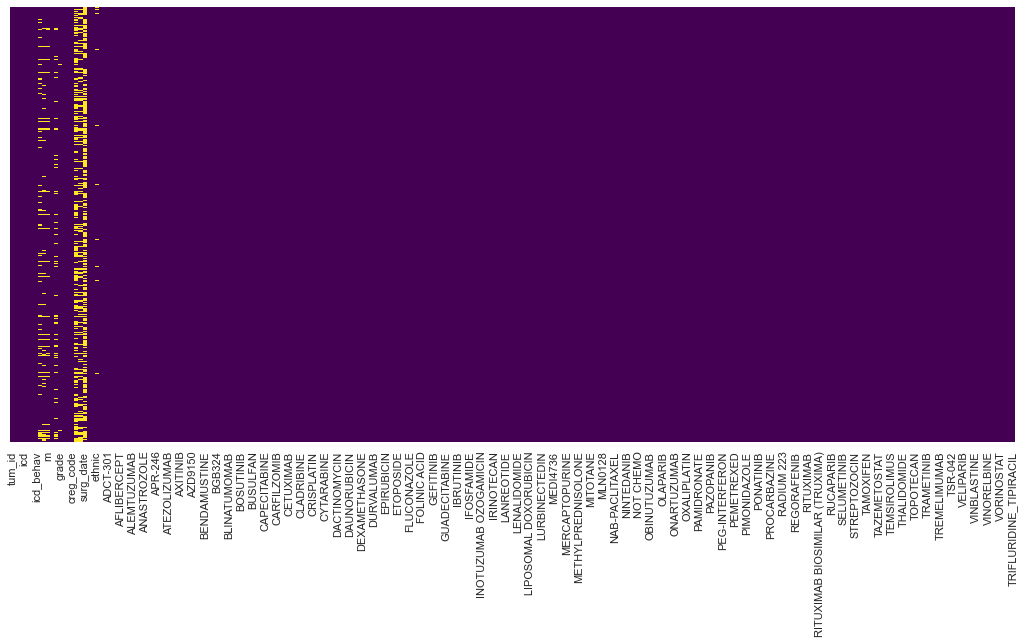

In [10]:
# Heatmap visualising missing data (isnull)
sns.set(rc = {'figure.figsize':(18,8)})
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis');

- remove t,n, stage_sys, ccp, perform_status and surg_date columns
- remove rows with missing m, grade, ethnic, 

In [6]:
#also remove tum_id, pt_id, diag_date, icd_2 and creg_code columns as not useful
df.drop(columns= ['tum_id', 'pt_id', 'diag_date','icd_2', 'creg_code', 't','n', 
                  'stage_sys', 'ccp', 'perform_status', 
                  'surg_date'], inplace=True)
df = df.drop(df.loc[df["m"].isnull()].index)
df =df.drop(df.loc[df["grade"].isnull()].index)
df = df.drop(df.loc[df["ethnic"].isnull()].index)

In [12]:
df.head()

,icd,icd_morph,icd_behav,m,stage,grade,age,sex,laterality,quint_2015,...,VINBLASTINE,VINCRISTINE,VINFLUNINE,VINORELBINE,VISMODEGIB,VISTUSERTIB,VORINOSTAT,X-396,ZOLEDRONIC ACID,TRIFLURIDINE_TIPIRACIL
0,C343,8041,3,1b,4,GX,80,male,R,4,...,0,0,0,0,0,0,0,0,0,0
1,C341,8070,3,0,2A,GX,46,male,R,2,...,0,0,0,0,0,0,0,0,0,0
3,C341,8070,3,0,3B,G3,69,male,L,1 - least deprived,...,0,1,0,0,0,0,0,0,0,0
4,C340,8140,3,1b,4,GX,85,female,R,3,...,0,1,0,0,0,0,0,0,0,0
5,C349,8072,3,1b,4,G3,81,male,R,1 - least deprived,...,0,1,0,0,0,0,0,0,1,0


## Analyze the target - survival status

In [7]:
df.survived.value_counts()

D    24583
A    10221
X        6
Name: survived, dtype: int64

- D = Dead
- A = Alive
- X = not known, therefore will remove these rows

In [8]:
df.drop(df.loc[df['survived']=='X'].index, inplace=True)

In [9]:
#change D and A to 0 and 1, respectively 
for i in df.index:
    if df.loc[i, 'survived'] == 'D':
        df.loc[i, 'survived'] = 0
    else:
        df.loc[i, 'survived'] = 1

- Changed D to 0 and A to 1 to be able to calculate correlations

In [13]:
df.survived.value_counts()

0    24583
1    10221
Name: survived, dtype: int64

In [27]:
df.shape

(34804, 239)

In [30]:
df.head()

,icd,icd_morph,icd_behav,m,stage,grade,age,sex,laterality,quint_2015,ethnic,survived,ACELARIN,ADCT-301,ADI-PEG 20,AFATINIB,AFLIBERCEPT,ALDESLEUKIN,ALECTINIB,ALEMTUZUMAB,AMSACRINE,ANAGRELIDE,ANASTROZOLE,ANETUMAB RAVTANSINE,APATORSEN,APR-246,ARSENIC TRIOXIDE,ASPARAGINASE,ATEZOLIZUMAB,ATG,AVELUMAB,AXITINIB,AZACITIDINE,AZD5363,AZD9150,BAY1895344,BCG,BENDAMUSTINE,BEVACIZUMAB,BEXAROTENE,BGB324,BICALUTAMIDE,BLEOMYCIN,BLINATUMOMAB,BMS-986016,BORTEZOMIB,BOSUTINIB,BRENTUXIMAB VEDOTIN,BRIGATINIB,BUSULFAN,CABAZITAXEL,CABOZANTINIB,CAPECITABINE,CAPMATINIB,CARBOPLATIN,CARFILZOMIB,CARMUSTINE,CERITINIB,CETUXIMAB,CHLORAMBUCIL,CISPLATIN,CLADRIBINE,CLOFARABINE,CPX - 351,CRISPLATIN,CRIZOTINIB,CYCLOPHOSPHAMIDE,CYTARABINE,DABRAFENIB,DACARBAZINE,DACTINOMYCIN,DARATUMUMAB,DASATINIB,DAUNORUBICIN,DEFACTINIB,DENOSUMAB,DEXAMETHASONE,DOCETAXEL,DOXORUBICIN,DURVALUMAB,ENTRECTINIB,ENZALUTAMIDE,EPIRUBICIN,ERIBULIN,ERLOTINIB,ETOPOSIDE,EVEROLIMUS,EXEMESTANE,FLUCONAZOLE,FLUDARABINE,FLUOROURACIL,FOLINIC ACID,FULVESTRANT,GANETESPIB,GEFITINIB,GEMCITABINE,GEMTUZUMAB OZOGAMYCIN,GUADECITABINE,HYDROCORTISONE,HYDROXYCARBAMIDE,IBRUTINIB,IDARUBICIN,IDELALISIB,IFOSFAMIDE,IMATINIB,IMCGP100,INOTUZUMAB OZOGAMICIN,INTERFERON,IPILIMUMAB,IRINOTECAN,IXAZOMIB,JNJ-42756493,LANREOTIDE,LAPATINIB,LCL161,LENALIDOMIDE,LENVATINIB,LIPOSOMAL DAUNORUBICIN,LIPOSOMAL DOXORUBICIN,LOMUSTINE,LORLATINIB,LURBINECTEDIN,LY2606368,MED14736,MEDI4736,MEDROXYPROGESTERONE,MELPHALAN,MERCAPTOPURINE,MESNA,METHOTREXATE,METHYLPREDNISOLONE,MIFAMURTIDE,MITOMYCIN,MITOTANE,MITOXANTRONE,MK-3475,MLN0128,MLN1117,MSB0011359C,NAB-PACLITAXEL,NELARABINE,NILOTINIB,NINTEDANIB,NIVOLUMAB,NKTR-214,NOT CHEMO,NOT MATCHED,NUC-3373,OBINUTUZUMAB,OCTREOTIDE,OFATUMUMAB,OLAPARIB,OLARATUMAB,OMO-1,ONARTUZUMAB,ONO/GS-4059,OSIMERTINIB,OXALIPLATIN,PACLITAXEL,PALBOCICLIB,PAMIDRONATE,PANITUMUMAB,PANOBINOSTAT,PAZOPANIB,PDR001,PEG-ASPARAGINASE,PEG-INTERFERON,PEGINTERFERON ALFA,PEMBROLIZUMAB,PEMETREXED,PENTOSTATIN,PERTUZUMAB,PIMONIDAZOLE,PIXANTRONE,POMALIDOMIDE,PONATINIB,PREDNISOLONE,PREDNISONE,PROCARBAZINE,QUIZARTINIB,RA223,RADIUM 223,RALTITREXED,RAMUCIRUMAB,REGORAFENIB,RIBOCICLIB,RILOTUMUMAB,RITUXIMAB,RITUXIMAB BIOSIMILAR,RITUXIMAB BIOSIMILAR (RIXATHON),RITUXIMAB BIOSIMILAR (TRUXIMA),RITXUIMAB BIOSIMILAR (RIXATHON),ROCILETINIB,RUCAPARIB,RUXOLITINIB,SAVOLITINIB,SELUMETINIB,SORAFENIB,STEROID,STREPTOZOCIN,SUNITINIB,TALIMOGENE LAHERPAREPVEC,TAMOXIFEN,TAS-116,TASELISIB,TAZEMETOSTAT,TEFINOSTAT,TEMOZOLOMIDE,TEMSIROLIMUS,TEYSUNO,TGR-1202,THALIDOMIDE,THIOTEPA,TIVOZANIB,TOPOTECAN,TOSEDOSTAT,TRABECTEDIN,TRAMETINIB,TRASTUZUMAB,TRASTUZUMAB EMTANSINE,TREMELIMUMAB,TREOSULFAN,TRETINOIN,TSR-042,UBLITUXIMAB,VANDETANIB,VELIPARIB,VEMURAFENIB,VENETOCLAX,VINBLASTINE,VINCRISTINE,VINFLUNINE,VINORELBINE,VISMODEGIB,VISTUSERTIB,VORINOSTAT,X-396,ZOLEDRONIC ACID,TRIFLURIDINE_TIPIRACIL
0,C343,8041,3,1b,4,GX,80,male,R,4,A,Dead,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C341,8070,3,0,2A,GX,46,male,R,2,A,Alive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,C341,8070,3,0,3B,G3,69,male,L,1 - least deprived,A,Dead,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
df = pd.read_csv('../../../../Capstone/drug_lung_clean_tableau.csv',low_memory=False)

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


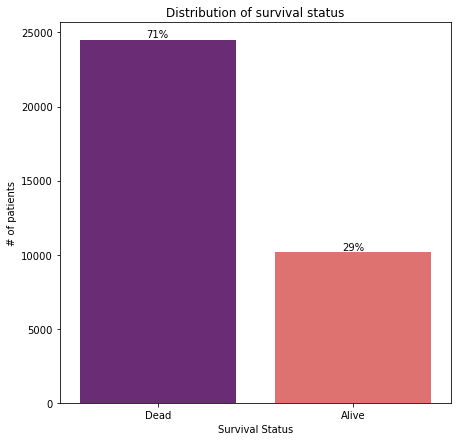

In [25]:
plt.figure(figsize=(7,7))
ax = sns.countplot(df.survived, palette='magma');

###Adding percents over bars
# Getting heights of our bars
height = [p.get_height() if p.get_height()==p.get_height() else 0 for p in ax.patches]

# Counting number of bar groups
ncol = int(len(height)/2)

# Counting total height of groups
total = [height[i] + height[i + ncol] for i in range(ncol)] * 2

# Looping through bars
for i, p in enumerate(ax.patches):    
    # Adding percentages   
    ax.text(p.get_x()+p.get_width()/2, height[i]*1.01 + 10,
                '{:1.0%}'.format(height[i]/total[i]), ha="center", size=10) 
plt.title('Distribution of survival status')
plt.xlabel("Survival Status");
plt.ylabel("# of patients");

- Much higher number of 0 (not survived) vs 1 (survived) 
 - Indication of class inbalance

### Correlation with categorical variables 

#### Patient demographics

In [18]:
from scipy.stats import chi2_contingency

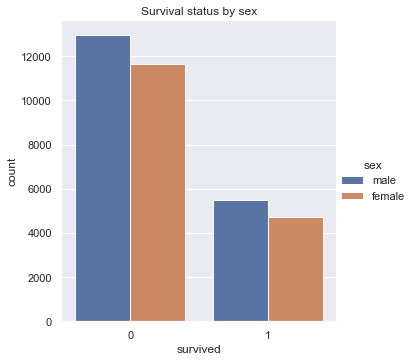

In [19]:
sns.catplot(x="survived", hue='sex', kind="count", data=df)
plt.title('Survival status by sex')
plt.show()

In [20]:
df[['sex', 'survived']].groupby(['sex'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,sex,survived
0,male,0.297168
1,female,0.289737


In [21]:
csq=chi2_contingency(pd.crosstab(df['survived'], df['sex']))
print("P-value: ",csq[1])

P-value:  0.13169301033620742


- Trend appears similar for males and females in both survived and not survived
- Male slighlty higher survival but unlikely to be significant 
- Sex may not be a very useful predictor for survival status as chi2 p value is not significant (>0.05)

In [22]:
df.ethnic.value_counts()

A    31104
C     1016
Z      729
B      432
S      289
M      216
H      209
X      153
L      139
J      130
N       79
R       78
K       71
P       52
G       45
D       25
0       16
F       14
E        7
Name: ethnic, dtype: int64

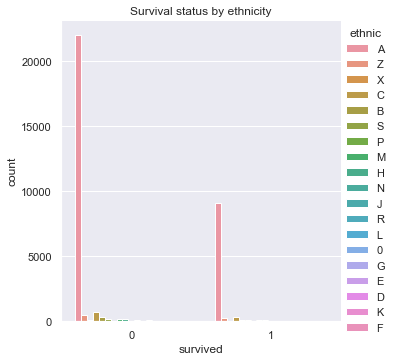

In [23]:
# fig, ax = plt.subplots(figsize=(20,20))
#add right lables 
sns.catplot(x="survived", hue='ethnic', kind="count", data=df) #, ax=ax)
plt.title('Survival status by ethnicity')
plt.show()

In [24]:
df[["ethnic", "survived"]].groupby(['ethnic'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,ethnic,survived
0,S,0.366782
1,M,0.356481
2,X,0.346405
3,H,0.334928
4,D,0.320000
5,C,0.317913
6,N,0.316456
7,0,0.312500
8,Z,0.311385
9,J,0.307692


In [25]:
csq=chi2_contingency(pd.crosstab(df['survived'], df['ethnic']))
print("P-value: ",csq[1])

P-value:  0.05833343787055462


- Majority of patients are A ('White British')
- Highest survival amongst S ('any other ethnic group') and M ('black carribean') and lowest amongst P ('any other black bkgrd') and E ('mixed white and black african')
- Chi^2 test is not significant between survived and ethnic but only slightly higher than 0.05, so may still be a useful predictor 

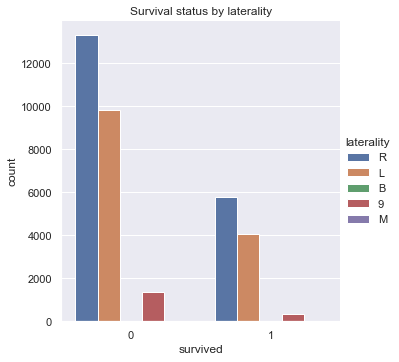

In [26]:
sns.catplot(x="survived", hue='laterality', kind="count", data=df) #, ax=ax)
plt.title('Survival status by laterality')
plt.show()

In [27]:
df[['laterality', 'survived']].groupby(['laterality'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,laterality,survived
0,M,0.470588
1,R,0.303504
2,B,0.296296
3,L,0.293003
4,9,0.187097


In [28]:
df.laterality.value_counts()

R    19120
L    13935
9     1705
B       27
M       17
Name: laterality, dtype: int64

- Higher number of R (right) handed compared to L (left) handed patients, which is to be expected 
- R slightly higher survival than L, but unlikely to be significant as numbers are very close 
 - Although M (midline) shows higher survival, according to graph above very few patients are midline so unlikely to be affect survival status 

#### Cancer details

In [29]:
df[['icd', 'survived']].groupby(['icd'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,icd,survived
0,C341,0.308722
1,C342,0.308563
2,C343,0.305447
3,C340,0.263813
4,C348,0.231707
5,C349,0.230741


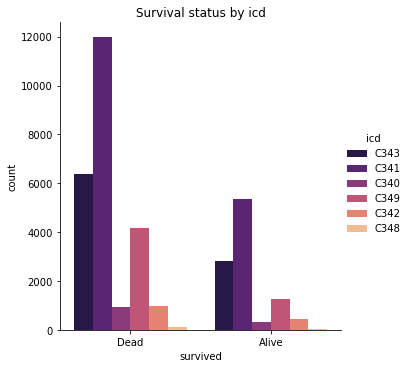

In [13]:
# sns.set(rc = {'figure.figsize':(18,18)})
#add proper labels
sns.catplot(x="survived", hue='icd', kind="count", data=df, palette='magma')
plt.title('Survival status by icd')
plt.show()

- C341	UPPER LOBE, BRONCHUS OR LUNG
- C342	MIDDLE LOBE, BRONCHUS OR LUNG
- C343	LOWER LOBE, BRONCHUS OR LUNG
- C348	OVERLAPPING LESION OF BRONCHUS AND LUNG
- C349	BRONCHUS OR LUNG, UNSPECIFIED

In [31]:
csq=chi2_contingency(pd.crosstab(df['survived'], df['icd']))
print("P-value: ",csq[1])

P-value:  3.331280122413154e-28


- C341 highest in both not survived and survived 
- C342 highest in survival and C349 lowest, explore significance
- Chi^2 p value <0.05, therefore may be significant predictor

In [32]:
df[['grade', 'survived']].groupby(['grade'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,grade,survived
0,G1,0.330677
1,G2,0.321214
2,GX,0.292701
3,G3,0.278596
4,G4,0.272321


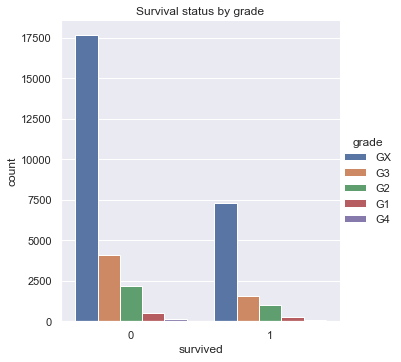

In [33]:
sns.catplot(x="survived", hue='grade', kind="count", data=df)
plt.title('Survival status by grade')
plt.show()

- GX (not known) highest number, therfore can't use grade as predictor
- G2 highest mean survival ; G3 lowest

In [34]:
df.grade.value_counts()

GX    24964
G3     5700
G2     3163
G1      753
G4      224
Name: grade, dtype: int64

In [32]:
#drop grade
df.drop(columns=['grade'], inplace=True)

In [36]:
df[['icd_morph', 'survived']].groupby(['icd_morph'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()


,icd_morph,survived
0,8804,1.0
1,9052,1.0
2,8441,1.0
3,8077,1.0
4,8461,1.0
...,...,...
92,8982,0.0
93,8721,0.0
94,8972,0.0
95,8044,0.0


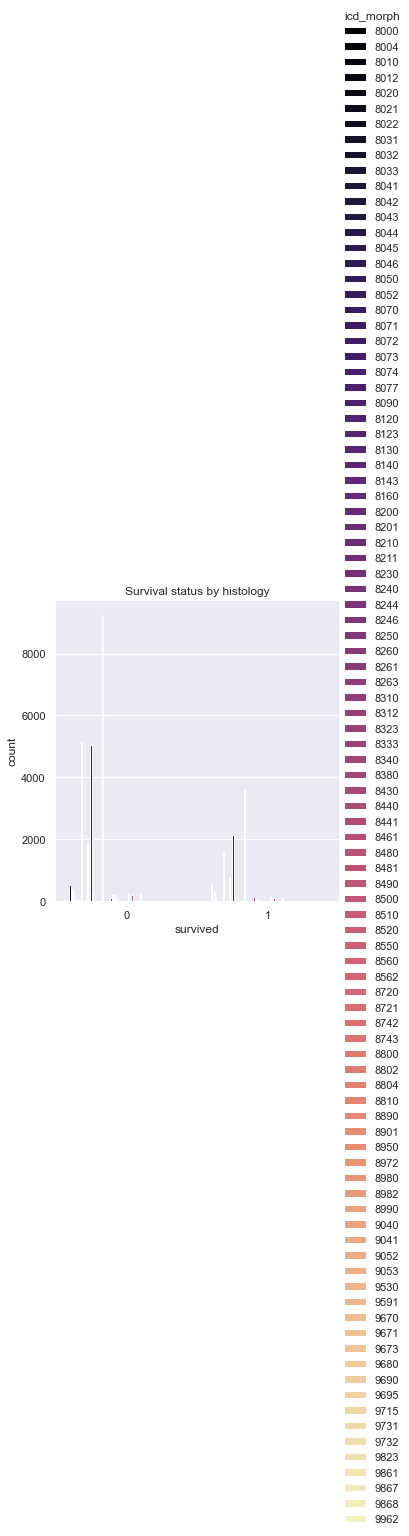

In [37]:
#might be better to show in table 
sns.catplot(x="survived", hue='icd_morph', kind="count", palette='magma', data=df)
plt.title('Survival status by histology')
plt.show()

In [38]:
df.icd_morph.value_counts()

8140    12880
8070     7209
8041     6758
8046     2641
8000     1093
        ...  
9731        1
8743        1
9671        1
9690        1
8510        1
Name: icd_morph, Length: 97, dtype: int64

- histology varied
- several histolgies with 1 mean survival and several as 0
- could be useful predictor

In [39]:
df.stage.value_counts()

4      15355
1A      4647
3A      4604
3B      3479
1B      2876
2A      1761
2B      1570
?        150
3        111
1         93
4C        44
2         36
U         27
4A        21
4B         9
3C         4
1A2        4
1A3        2
0          2
1E         2
2S         1
3E         1
3S         1
1B1        1
0A         1
2C         1
1C         1
Name: stage, dtype: int64

In [40]:
df[['stage', 'survived']].groupby(['stage'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,stage,survived
0,2C,1.000000
1,3S,1.000000
2,3E,1.000000
3,1B1,1.000000
4,1C,1.000000
5,1E,1.000000
6,1A,0.672477
7,1,0.645161
8,2,0.638889
9,1B,0.567455


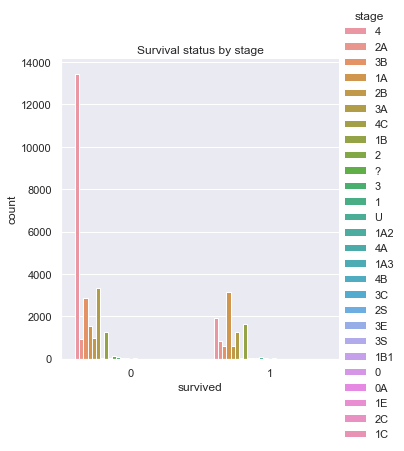

In [41]:
#clean up labels 
sns.catplot(x="survived", hue='stage', kind="count", data=df, )
plt.title('Survival status by stage')
plt.show()

- stage varied
- several stages with 1 mean survival and several as 0
- could be useful predictor
- remove rows with unknown (?) stage

In [12]:
df = df.drop(df.loc[df["stage"]=='?'].index)

In [43]:
df.icd_behav.value_counts()

3    34628
9        7
X        6
5        5
2        5
Name: icd_behav, dtype: int64

In [44]:
df[['icd_behav', 'survived']].groupby(['icd_behav'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,icd_behav,survived
0,5,0.800000
1,2,0.400000
2,3,0.293635
3,9,0.285714
4,X,0.000000


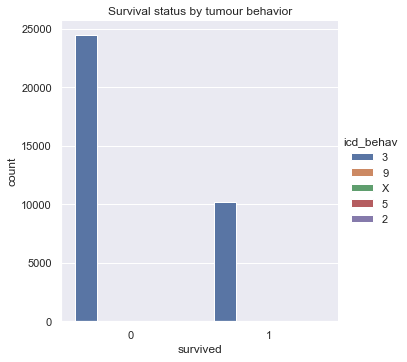

In [45]:
sns.catplot(x="survived", hue='icd_behav', kind="count", data=df)
plt.title('Survival status by tumour behavior')
plt.show()

- mostly all 3 (malignant)
- not a useful predictor 
- remove X (unknown) rows

In [13]:
df = df.drop(df.loc[df["icd_behav"]=='X'].index)

In [46]:
df.m.value_counts()

0     19262
1b     9483
1a     4259
1      1639
1c        6
X         5
Name: m, dtype: int64

In [47]:
df[['m', 'survived']].groupby(['m'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,m,survived
0,0,0.428876
1,X,0.400000
2,1,0.137279
3,1b,0.124539
4,1a,0.119277
5,1c,0.000000


In [ ]:
sns.catplot(x="survived", hue='m', kind="count", data=df)
plt.title('Survival status by cancer spread')
plt.show()

- As expected no metastasis (0) has highest survivability and metastisis (1, 1a, 1b, 1c) has lowest
- remove X (unknown) 

In [14]:
df = df.drop(df.loc[df["m"]=='X'].index)

In [19]:
df.quint_2015.value_counts()

5 - most deprived     8818
4                     7568
3                     6989
2                     6231
1 - least deprived    5037
Name: quint_2015, dtype: int64

In [20]:
df[['quint_2015', 'survived']].groupby(['quint_2015'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,quint_2015,survived
0,1 - least deprived,0.313679
1,3,0.298040
2,2,0.296742
3,4,0.295322
4,5 - most deprived,0.275346


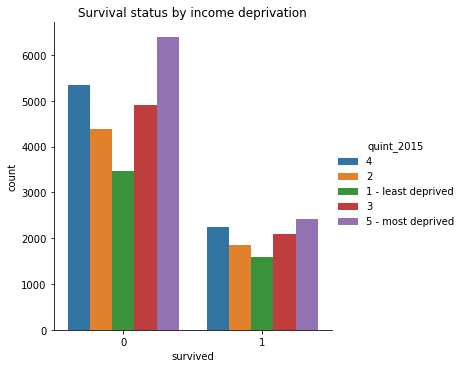

In [21]:
sns.catplot(x="survived", hue='quint_2015', kind="count", data=df)
plt.title('Survival status by income deprivation')
plt.show()

- highest number of patients in both groups belonged to most deprived 
- least deprived had highest survivabilty and most deprived had lowest survivability

### Correlation with Treatment

In [22]:
df[["PACLITAXEL", "survived"]].groupby(['PACLITAXEL'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,PACLITAXEL,survived
0,1,0.347489
1,0,0.288673


In [23]:
df.PACLITAXEL.value_counts()

0    31676
1     2967
Name: PACLITAXEL, dtype: int64

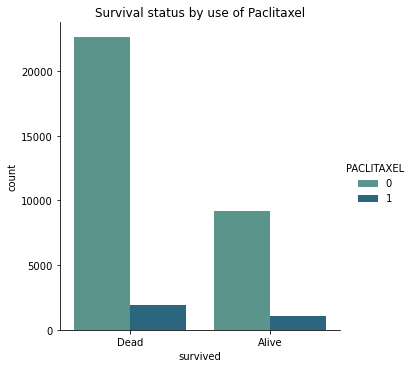

In [15]:
sns.catplot(x="survived", hue='PACLITAXEL', kind="count", data=df, palette='crest') #, ax=ax)
plt.title('Survival status by use of Paclitaxel')
plt.show()

In [25]:
df[["BEVACIZUMAB", "survived"]].groupby(['BEVACIZUMAB'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,BEVACIZUMAB,survived
0,1,0.631410
1,0,0.290641


In [26]:
df['BEVACIZUMAB'].value_counts()

0    34331
1      312
Name: BEVACIZUMAB, dtype: int64

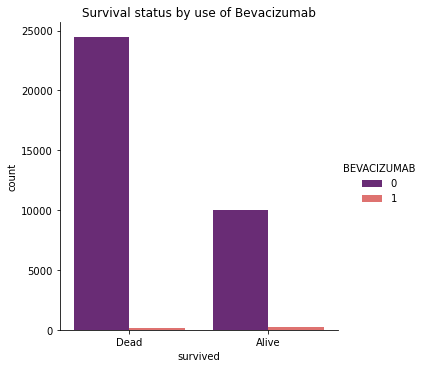

In [12]:
sns.catplot(x="survived", hue='BEVACIZUMAB', kind="count", data=df, palette='magma') #, ax=ax)
plt.title('Survival status by use of Bevacizumab')
plt.show()

In [28]:
df.PAZOPANIB.value_counts()

0    34458
1      185
Name: PAZOPANIB, dtype: int64

In [29]:
df['STEROID'].value_counts()

1    24047
0    10596
Name: STEROID, dtype: int64

In [30]:
df[["STEROID", "survived"]].groupby(['STEROID'], as_index=True).mean().sort_values(by='survived', ascending=False).reset_index()

,STEROID,survived
0,0,0.300585
1,1,0.290681


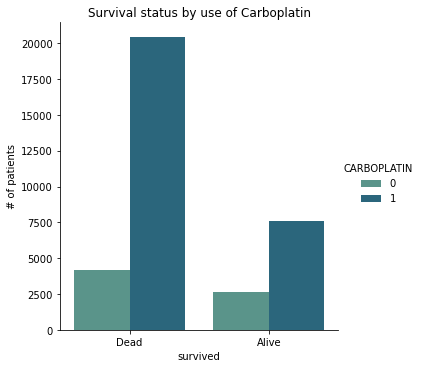

In [46]:
sns.catplot(x="survived", hue='CARBOPLATIN', kind="count", data=df, palette='crest') #, ax=ax)
plt.ylabel('# of patients')
plt.title('Survival status by use of Carboplatin')
plt.show()

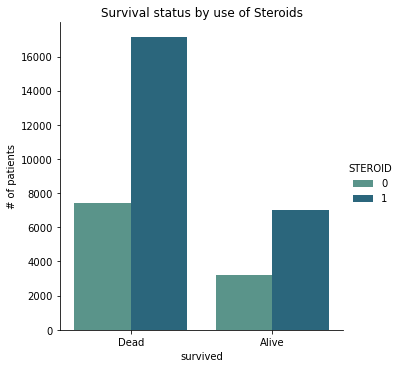

In [18]:
sns.catplot(x="survived", hue='STEROID', kind="count", data=df, palette='crest') #, ax=ax)
plt.ylabel('# of patients')
plt.title('Survival status by use of Steroids')
plt.show()

In [21]:
df.PEMBROLIZUMAB.value_counts()

0    25137
1     9667
Name: PEMBROLIZUMAB, dtype: int64

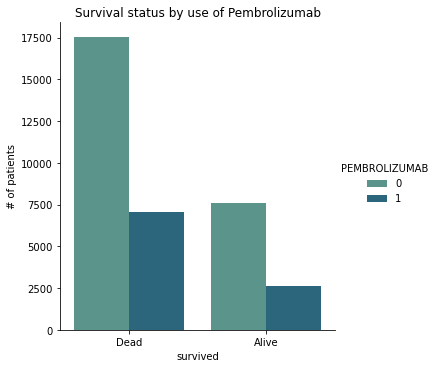

In [22]:
sns.catplot(x="survived", hue='PEMBROLIZUMAB', kind="count", data=df, palette='crest') #, ax=ax)
plt.ylabel('# of patients')
plt.title('Survival status by use of Pembrolizumab')
plt.show()

In [32]:
df['NOT CHEMO'].value_counts()

1    29248
0     5395
Name: NOT CHEMO, dtype: int64

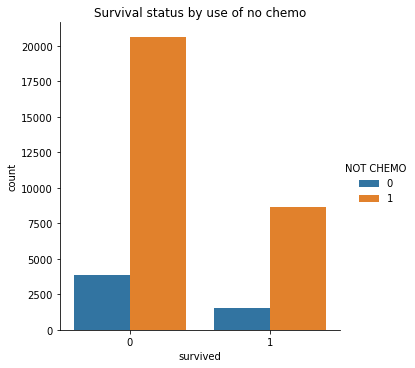

In [33]:
sns.catplot(x="survived", hue='NOT CHEMO', kind="count", data=df) #, ax=ax)
plt.title('Survival status by use of no chemo')
plt.show()

- Interesting that common chemo drugs such as paclitaxel and bevacizumab have higher number in class 0 
- Whereas, no chemo and steroid has higher count of non/survived patients
- Due to high number of drugs could not look at each individualy but will include in model

### Correlation with numerical variables 

In [34]:
#change survived col to integer
df["survived"] = pd.to_numeric(df["survived"])

In [35]:
df.groupby('survived')['age'].describe()


,count,mean,std,min,25%,50%,75%,max
survived,,,,,,,,
0,24468.0,70.502534,10.730541,3.0,64.0,71.0,78.0,103.0
1,10175.0,70.709582,10.824515,17.0,64.0,71.0,78.0,105.0


<Figure size 720x720 with 0 Axes>

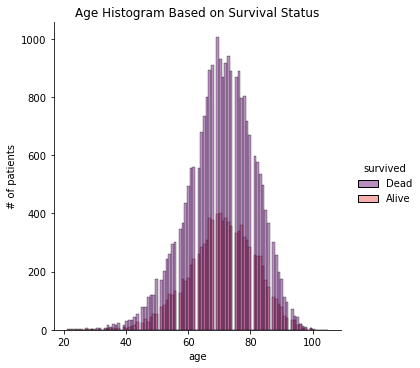

In [27]:
plt.figure(figsize=(10,10))
sns.displot(x='age', hue='survived', palette='magma', data=df)
plt.title('Age Histogram Based on Survival Status')
plt.ylabel('# of patients')
plt.show()

- Age for not survived and survived appear similarly distributed

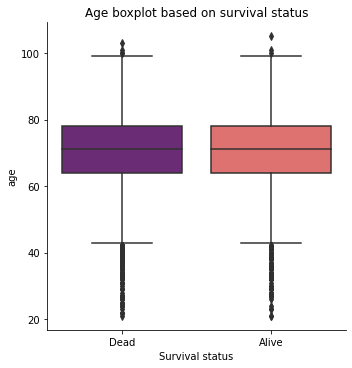

In [28]:
sns.catplot(x="survived", y="age", kind="box", data=df, palette='magma') 

plt.title('Age boxplot based on survival status')
plt.xlabel('Survival status')
plt.show()

- There are outliers in the age variable 
 - will remove rows where age < 20 as unlikely that young would have diagnosis

In [15]:
df = df[df['age']>20]

In [39]:
df.age.describe()

count    34635.000000
mean        70.576036
std         10.726956
min         21.000000
25%         64.000000
50%         71.000000
75%         78.000000
max        105.000000
Name: age, dtype: float64

In [40]:
df['survived'].corr(df['age'])

0.008651606007447774

- Age weakly correlated with survival

In [41]:
df.corr()

,icd_morph,age,survived,ACELARIN,ADCT-301,ADI-PEG 20,AFATINIB,AFLIBERCEPT,ALDESLEUKIN,ALECTINIB,...,VINBLASTINE,VINCRISTINE,VINFLUNINE,VINORELBINE,VISMODEGIB,VISTUSERTIB,VORINOSTAT,X-396,ZOLEDRONIC ACID,TRIFLURIDINE_TIPIRACIL
icd_morph,1.000000,-0.013377,0.015743,-0.005440,-0.002602,0.003615,-0.000108,-0.000978,-0.005440,0.000738,...,0.028107,0.001734,-0.003176,-0.019735,0.002597,0.001282,NaN,-0.003657,0.002416,-0.001324
age,-0.013377,1.000000,0.008652,0.000212,-0.004659,-0.008230,-0.002491,0.007206,0.002216,0.005295,...,-0.004884,0.017614,0.004728,-0.015118,-0.004177,-0.001656,NaN,0.000300,0.002765,0.010806
survived,0.015743,0.008652,1.000000,-0.003465,0.011784,0.004112,-0.025349,0.017593,0.008332,-0.003522,...,0.055187,0.065680,0.013128,-0.049529,0.007546,0.000886,NaN,0.003442,0.011275,0.046629
ACELARIN,-0.005440,0.000212,-0.003465,1.000000,-0.000041,-0.000383,-0.001644,-0.000132,-0.000029,-0.000254,...,-0.000387,-0.001270,-0.000076,-0.004878,-0.000123,-0.000116,NaN,-0.000041,-0.000386,-0.000237
ADCT-301,-0.002602,-0.004659,0.011784,-0.000041,1.000000,-0.000542,-0.002325,-0.000187,-0.000041,-0.000359,...,0.052443,0.032156,-0.000108,0.000736,-0.000173,-0.000163,NaN,-0.000058,-0.000546,-0.000335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VISTUSERTIB,0.001282,-0.001656,0.000886,-0.000116,-0.000163,-0.001532,0.003027,-0.000530,-0.000116,-0.001015,...,0.054667,0.030938,-0.000306,0.020983,-0.000490,1.000000,NaN,-0.000163,-0.001545,-0.000946
VORINOSTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X-396,-0.003657,0.000300,0.003442,-0.000041,-0.000058,-0.000542,-0.002325,-0.000187,-0.000041,-0.000359,...,-0.000548,-0.001796,-0.000108,-0.006898,-0.000173,-0.000163,NaN,1.000000,-0.000546,-0.000335
ZOLEDRONIC ACID,0.002416,0.002765,0.011275,-0.000386,-0.000546,-0.005122,0.014089,0.014633,-0.000386,0.005181,...,0.011713,0.028116,0.027384,0.022381,0.016078,-0.001545,NaN,-0.000546,1.000000,-0.003164


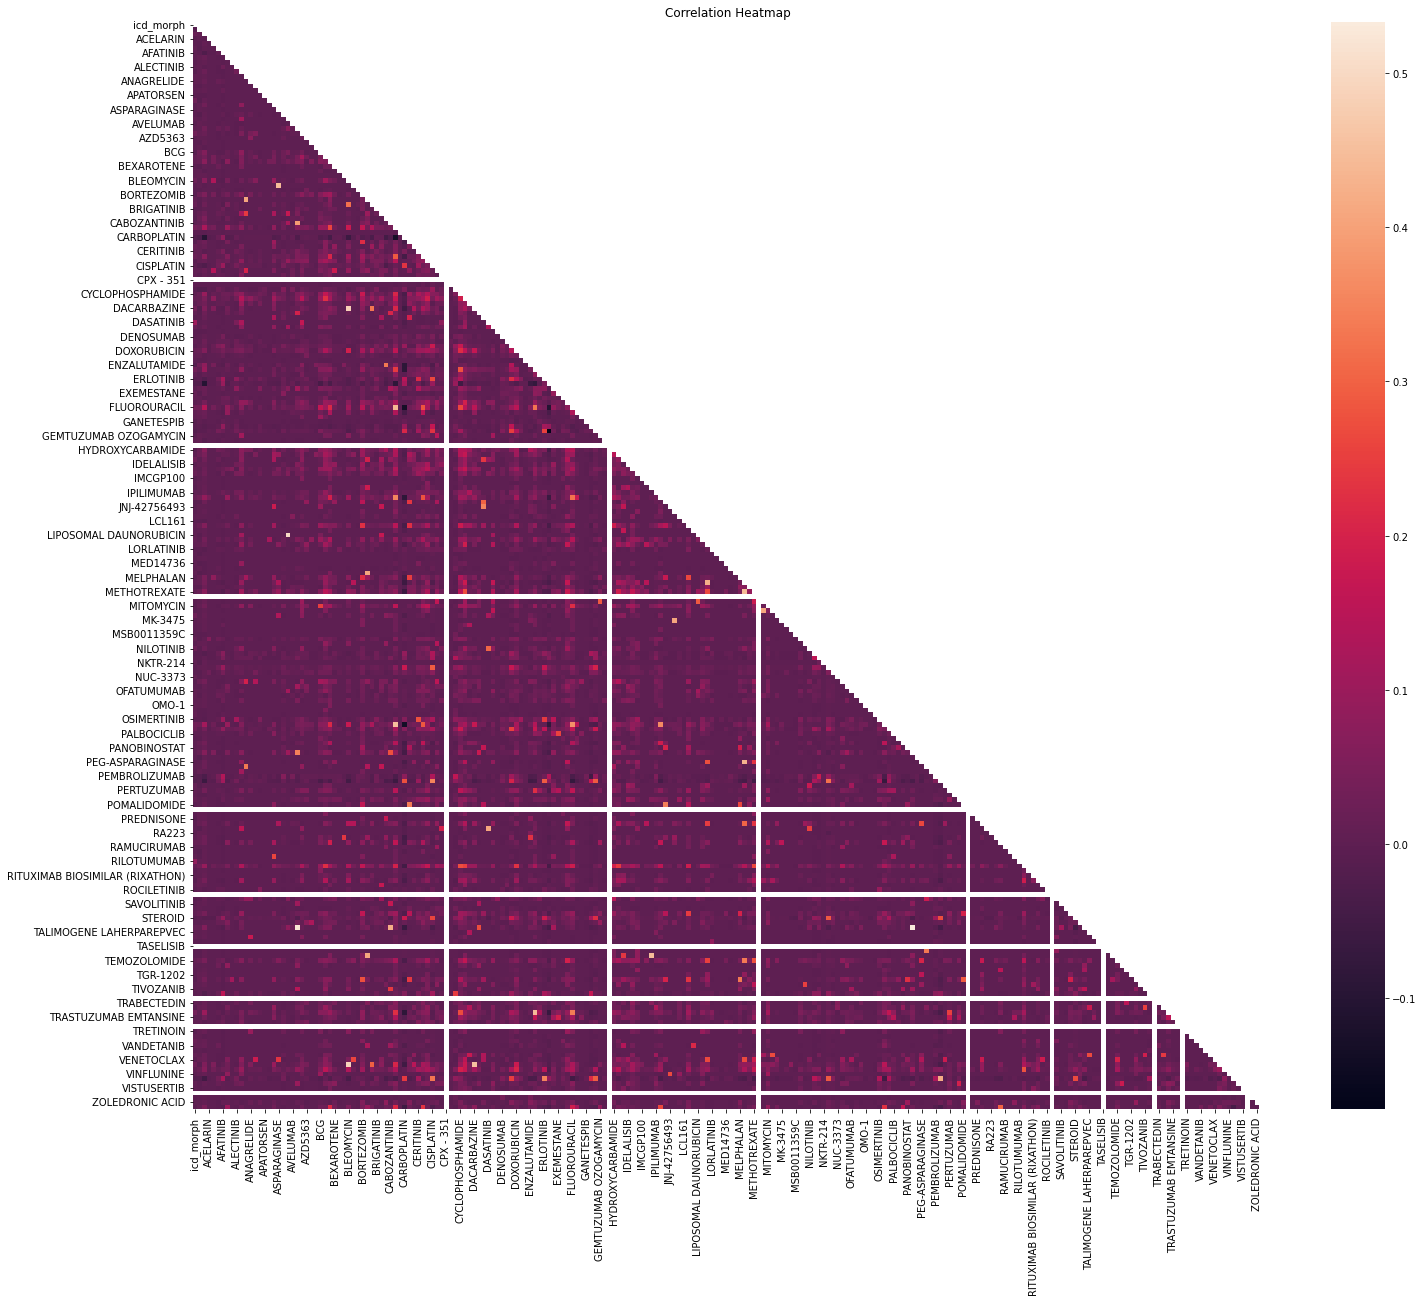

In [42]:
fig, ax = plt.subplots(figsize=(24, 20))
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), mask=mask, annot=False, ax=ax)
ax.set_title('Correlation Heatmap')
plt.show()

- Due to high number of features, it is difficult to vizualize correlations, but can spot a few light squares

# Modelling

## load in dataset

In [43]:
# df.to_csv('drug_lung_clean')

In [4]:
df = pd.read_csv('drug_lung_clean', low_memory=False)

#missed dropping 'grade' column in EDA so drop here
df.drop(columns=['Unnamed: 0', 'grade'], inplace=True)

In [5]:
df.head()

,icd,icd_morph,icd_behav,m,stage,age,sex,laterality,quint_2015,ethnic,...,CPX - 351,RUCAPARIB,METHYLPREDNISOLONE,IMCGP100,RITUXIMAB BIOSIMILAR,AZD9150,MIFAMURTIDE,LIPOSOMAL DAUNORUBICIN,MITOTANE,TOSEDOSTAT
0,C343,8041,3,1b,4,80,male,R,4,A,...,0,0,0,0,0,0,0,0,0,0
1,C341,8070,3,0,2A,46,male,R,2,A,...,0,0,0,0,0,0,0,0,0,0
2,C341,8070,3,0,3B,69,male,L,1 - least deprived,A,...,0,0,0,0,0,0,0,0,0,0
3,C340,8140,3,1b,4,85,female,R,3,A,...,0,0,0,0,0,0,0,0,0,0
4,C349,8072,3,1b,4,81,male,R,1 - least deprived,A,...,0,0,0,0,0,0,0,0,0,0


## dummify columns

In [6]:
#dummify categorical variables 
df2 = pd.get_dummies(df, columns=['icd','icd_morph','icd_behav','m','stage', 
                                  'sex','laterality','quint_2015','ethnic'])

In [7]:
df2.shape

(34646, 404)

In [8]:
#drop sex_male since sex_female will be sufficient
df2.drop(columns='sex_male', inplace=True)

In [9]:
df2.head()

,age,survived,PEMBROLIZUMAB,SUNITINIB,STEROID,NOT CHEMO,RITUXIMAB,DOCETAXEL,FLUOROURACIL,VINORELBINE,...,ethnic_J,ethnic_K,ethnic_L,ethnic_M,ethnic_N,ethnic_P,ethnic_R,ethnic_S,ethnic_X,ethnic_Z
0,80,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,46,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,69,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,85,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,81,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Baseline accuracy

In [9]:
df2.survived.value_counts(normalize=True)

0    0.706315
1    0.293685
Name: survived, dtype: float64

- Want an accuracy score > 0.70
- There may be class imbalance so will address by running models using SMOTE

## Classification models (no SMOTE)

In [10]:
sc = StandardScaler()

In [11]:
kf = StratifiedKFold(n_splits=5)

In [12]:
y = df2.pop('survived')

In [13]:
X = df2

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = pd.DataFrame(sc.fit_transform(X_train),
                       columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),
                     columns = X_test.columns)

In [22]:
#without SMOTE
models = [KNeighborsClassifier(n_neighbors=10),
          LogisticRegression(C= 1000, 
                             penalty= 'l2', 
                             solver='liblinear'),
          DecisionTreeClassifier(criterion='gini',
                                ccp_alpha= 0, 
                                 max_depth= None, 
                                 max_features= 1, 
                                 min_samples_split= 2, 
                                    random_state=42),
          RandomForestClassifier()]


for model in models:
    print(model)
    model.fit(X_train, y_train)
    print (f'score of train data: {model.score(X_train, y_train)}')
    print (f'score of test data: {model.score(X_test, y_test)}')
    print (f'mean cross val score: {np.mean(cross_val_score(model, X_train, y_train, cv=kf))}')
    print()
    print('-'*60)
    print()

KNeighborsClassifier(n_neighbors=10)
score of train data: 0.783987588396594
score of test data: 0.744011544011544
mean cross val score: 0.7470775706343089

------------------------------------------------------------

LogisticRegression(C=1000, solver='liblinear')
score of train data: 0.7808125270601819
score of test data: 0.7722943722943723
mean cross val score: 0.7738489896256449

------------------------------------------------------------

DecisionTreeClassifier(ccp_alpha=0, max_features=1, random_state=42)
score of train data: 0.9999278395150816
score of test data: 0.6673881673881674
mean cross val score: 0.6683864885290106

------------------------------------------------------------

RandomForestClassifier()
score of train data: 0.9999278395150816
score of test data: 0.7678210678210678
mean cross val score: 0.7731634598087782

------------------------------------------------------------



- Scores were higher than baseline for all models except the decision Tree
- Scores for train data for decision tree and random forest too high, indicating major overfitting, therefore will continue with a logistic regression model as the score is very close to random forest model and not at risk of overfitting the training data

In [16]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
print (f'score of train data: {xg.score(X_train, y_train)}')
print (f'score of test data: {xg.score(X_test, y_test)}')
print (f'mean cross val score: {np.mean(cross_val_score(xg, X_train, y_train, cv=kf))}')

score of train data: 0.7857916005195555
score of test data: 0.7777777777777778
mean cross val score: 0.7803434918760555


- XGBoost highest score 
- evaluate feature importance below

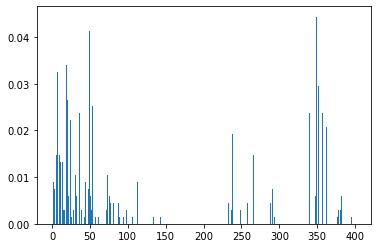

In [25]:
# print(xg.feature_importances_)
# plot
plt.bar(range(len(xg.feature_importances_)), xg.feature_importances_)
plt.show()

In [27]:
from xgboost import plot_importance

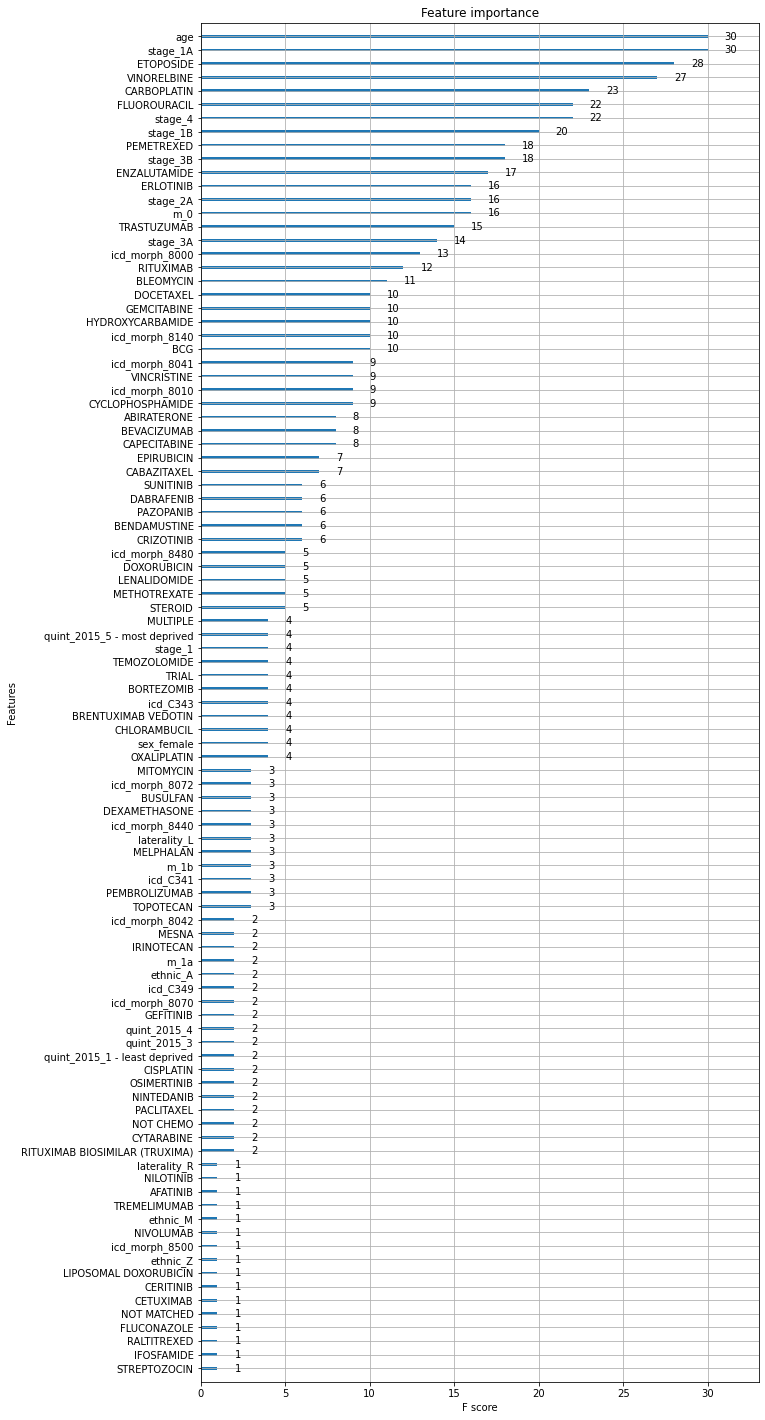

In [33]:
fig, ax = plt.subplots(figsize=(10,25))
# plt.figure(figsize=(20,20))
plot_importance(xg, ax=ax)
plt.show()

## Logisitic regression (unbalanced)

#### Fine tune model with GridSearchCV

In [21]:
log_params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': np.logspace(-4, 4, 9)}
gs = GridSearchCV(log, log_params, cv=kf, n_jobs=2, verbose=1)


In [22]:
#add max iter to model above to get rid of the warning message
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [23]:
print('best parameters:',gs.best_params_)
print('best score:',gs.best_score_)
best_logreg = gs.best_estimator_
print('train score:',best_logreg.score(X_train, y_train))
print('test score:',best_logreg.score(X_test, y_test))

best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
best score: 0.7773127072378381
train score: 0.7830855823351133
test score: 0.7734487734487735


- Score improved slightly with GridSearchCV (0.777 < 0.773), therefore will continue with fine tuned version

#### Feature Importance

In [42]:
log_2 = LogisticRegression(C= 0.001, 
                             penalty= 'l2', 
                             solver='liblinear',
                          max_iter=1000)

In [43]:
log_2.fit(X_train, y_train)
print(log_2.score(X_train, y_train))
print(log_2.score(X_test, y_test))
print(cross_val_score(log_2, X_train, y_train, cv=kf).mean())

0.7822432927486263
0.7761815831058756
0.7762811969172534


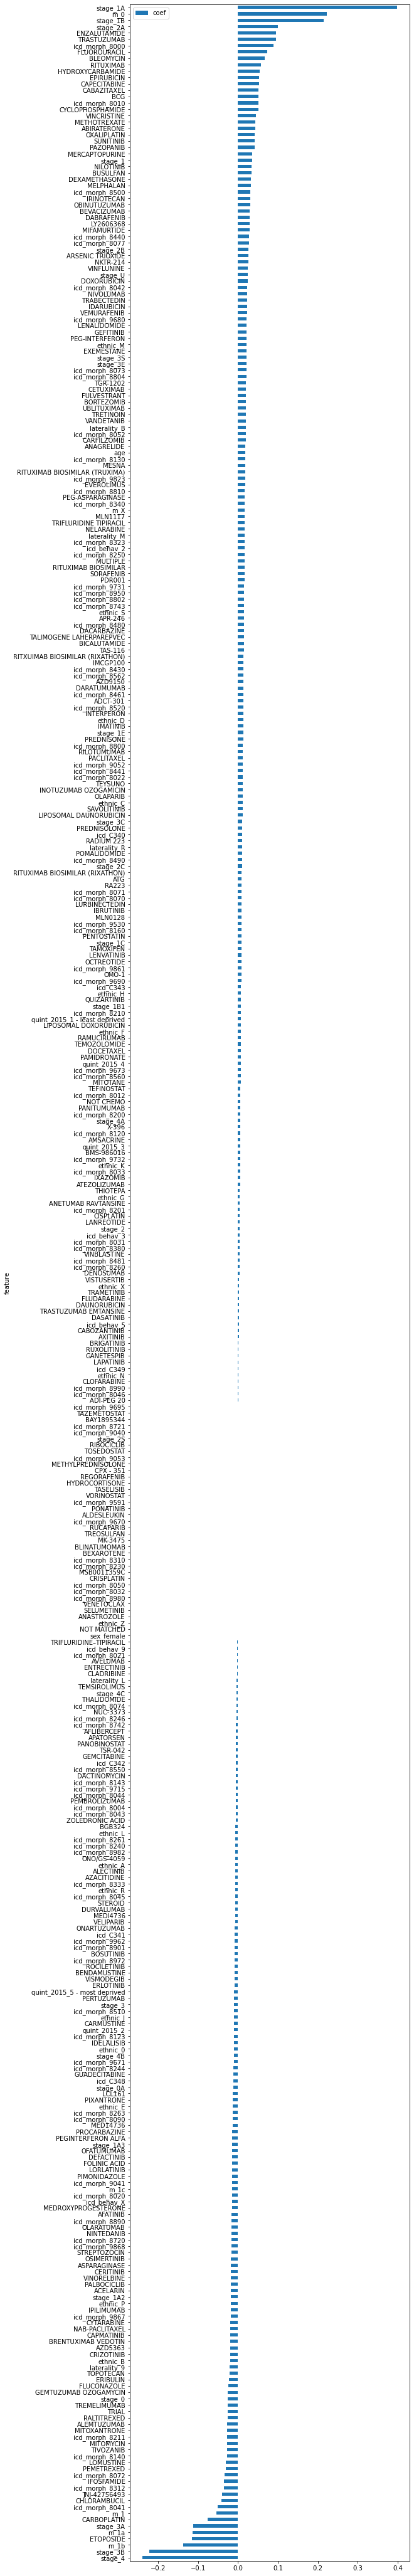

In [57]:
## plot all the features 
pd.DataFrame(list(zip(X.columns, log_2.coef_[0])), 
             columns=['feature', 'coef'])\
    .sort_values(by='coef') \
    .plot(kind='barh', x='feature', y='coef', figsize=(8, 75))
plt.show()

In [44]:
#create a df with 20 highest coefs and 20 lowest coefs
feat_1 =pd.DataFrame(list(zip(X.columns, log_2.coef_[0])), columns=['feature', 'coef']).sort_values(by='coef')[:20]
feat_2 =pd.DataFrame(list(zip(X.columns, log_2.coef_[0])), columns=['feature', 'coef']).sort_values(by='coef')[380:402]
feat_im = pd.concat([feat_1.reset_index(drop=True), feat_2.reset_index(drop=True)], axis=0)

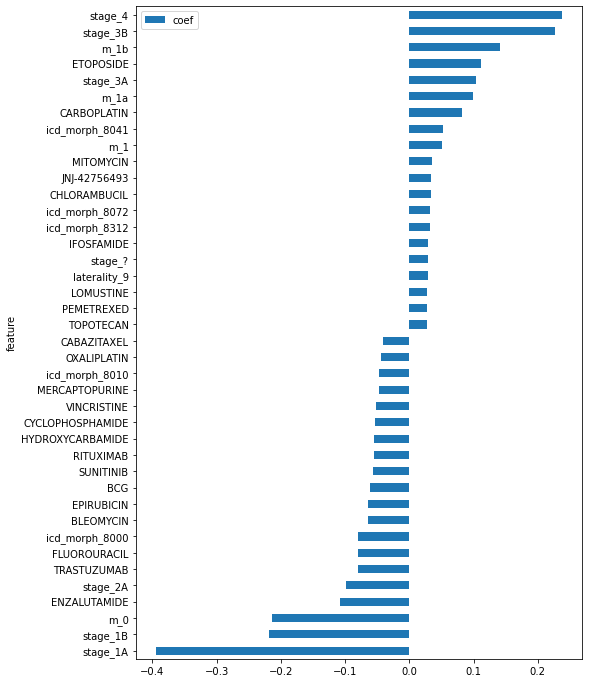

In [45]:
#plot df of top 20/lowest 20 coefs 
feat_im.plot(kind='barh', x='feature', y='coef', figsize=(8, 12))
plt.show()

- The plot above shows that, unsurpringly, early stage lung cancer (1A, 1B) has greater impact on the survived class vs late stage lung cancer (3, 4B), which has a greater impact in predicting the not survived class
- Certain morphologies are also stronger predictors of survived class (8000-neoplasm malignant) vs others which are stronger for the not survived class (8312-carcinoma renal cell)
- Drugs that were stronger predictors of survival included: mifamurtide, trastuzumab, enzalutamide, and vinflunine
- Drugs that were stronger predictors of not survival included: etoposide, carboplatin, capmatinib, and gemtuzumab ozogamycin
- Interestingly, the ethnicity E - mixed white and black african was a stronger predictor for not survived 


#### Model interpretation

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


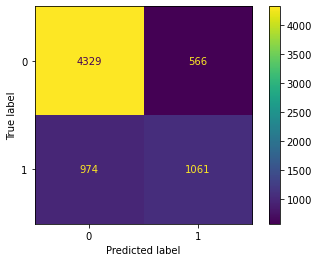

In [16]:
plot_confusion_matrix(xg, X_test, y_test)

- True Negatives (TN; yellow square) = Actual not survived and predicted not survived
- True Positives (TP; bottom right square) = Actual survived and predicted survived
- False Negatives (FN; bottom left square) = Actual survived but predicted not survived
- False Positive (FP; top right square) = Actual not survived but predicted survived

- Quick glance at the confusion plot shows that the TP and TN are higher than the FN and FP

In [17]:
predictions = xg.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7777777777777778


- Accuracy score of 0.77 = 77% of true positives and true negatives were predicted over all cases

In [18]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.8163    0.8844    0.8490      4895
           1     0.6521    0.5214    0.5795      2035

    accuracy                         0.7778      6930
   macro avg     0.7342    0.7029    0.7142      6930
weighted avg     0.7681    0.7778    0.7698      6930



- We want to have low false positive rate: low rate of predicting survival when actual class= not survived
 - Therefore we want a higher precision score
- This will increase the FN rate and therefore increase the recall

In [20]:
results = []
for cutoff in np.arange(0, 1.1, 0.1):
    pred = pd.DataFrame(np.where(xg.predict_proba(X_test)[:,1] > cutoff, 1, 0 ))
    precision = precision_score(y_test, pred )
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    results.append((cutoff, precision, recall, f1))
pd.DataFrame(results, columns=["CUTOFF", "PRECISION", "RECALL", "F1"]).sort_values("PRECISION", ascending=False)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,CUTOFF,PRECISION,RECALL,F1
8,0.8,0.848921,0.057985,0.108556
9,0.9,0.838710,0.012776,0.025169
7,0.7,0.788530,0.108108,0.190147
6,0.6,0.686505,0.402457,0.507435
5,0.5,0.652120,0.521376,0.579465
4,0.4,0.600455,0.649140,0.623849
3,0.3,0.569934,0.722850,0.637348
2,0.2,0.483999,0.839803,0.614086
1,0.1,0.369497,0.932187,0.529223
0,0.0,0.293651,1.000000,0.453988


- Since increasing precision score decreases the recall score, a good cutoff point to optimize precision while not having the lowest recall score may be 0.7 

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


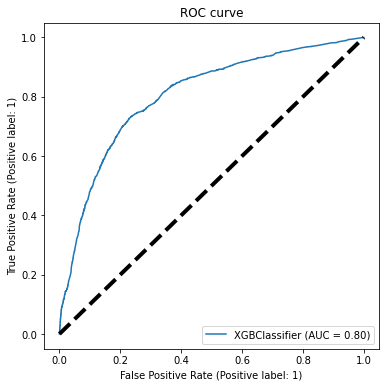

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(xg, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.title('ROC curve')
plt.show()

- The ROC plot above indicates the logistic regression model classifies 80% (AUC) of predictions correctly
- It also indicates that a threshold of 0.7-0.8 is optimal for reducing the false positive rate, which is similar to the cutoff table above

## Classification models using SMOTE 

- Applying SMOTE to balance out the target classes

In [17]:
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [18]:
before = y_train.value_counts()
print(f'before resampling with SMOTE:\n{before}')

before resampling with SMOTE:
0    19576
1     8140
Name: survived, dtype: int64


In [19]:
after = y_train_sm.value_counts()
print(f'after resampling with SMOTE:\n{after}')

after resampling with SMOTE:
1    19576
0    19576
Name: survived, dtype: int64


In [20]:
y_train_sm.value_counts(normalize=True)

1    0.5
0    0.5
Name: survived, dtype: float64

- baseline acccuracy = 0.5

In [22]:
#with SMOTE
models = [KNeighborsClassifier(n_neighbors=10),
          LogisticRegression(C= 1000, 
                             penalty= 'l2', 
                             solver='liblinear'),
          DecisionTreeClassifier(criterion='gini',
                                ccp_alpha= 0, 
                                 max_depth= None, 
                                 max_features= 1, 
                                 min_samples_split= 2, 
                                    random_state=42),
          RandomForestClassifier(),
         XGBClassifier()]


for model in models:
    print(model)

    model.fit(X_train_sm, y_train_sm)
    print (f'score of train data: {model.score(X_train_sm, y_train_sm)}')
    print (f'score of test data: {model.score(X_test, y_test)}')
    print (f'mean cross val score: {np.mean(cross_val_score(model, X_train_sm, y_train_sm, cv=kf))}')
    print()

    print('-'*60)
    print()

KNeighborsClassifier(n_neighbors=10)
score of train data: 0.8038925214548427
score of test data: 0.6751803751803752
mean cross val score: 0.7558762412803162

------------------------------------------------------------

LogisticRegression(C=1000, solver='liblinear')
score of train data: 0.7571260727421332
score of test data: 0.7506493506493507
mean cross val score: 0.7520693781289381

------------------------------------------------------------

DecisionTreeClassifier(ccp_alpha=0, max_features=1, random_state=42)
score of train data: 0.999948917041275
score of test data: 0.6613275613275613
mean cross val score: 0.7366473261049634

------------------------------------------------------------

RandomForestClassifier()
score of train data: 0.9999233755619126
score of test data: 0.7705627705627706
mean cross val score: 0.8298495011067942

------------------------------------------------------------



In [21]:
xg_smt = XGBClassifier()
xg_smt.fit(X_train_sm, y_train_sm)
print (f'score of train data: {xg_smt.score(X_train_sm, y_train_sm)}')
print (f'score of test data: {xg_smt.score(X_test, y_test)}')
print (f'mean cross val score: {np.mean(cross_val_score(xg_smt, X_train_sm, y_train_sm, cv=kf))}')

score of train data: 0.8412852472415202
score of test data: 0.7738816738816738
mean cross val score: 0.8147541951438051


- All classification models had higher score than baseline (0.50)
- Decision tree, random forest and KNN models were higher with balanced compared to unbalanced data
 - However, decision tree and random forest models had a 0.99 score on train data (major overfitting), will tune with gridsearch
- Logistic regression model score was lower with balanced compared to unbalanced data
- Because random forest model had a high cross-val score will use gridsearch to optimize the parameters and score, and reduce overfitting on training data
- Best score with XGBoost

## Random forest classifier on balanced data

#### GridSearchCV to tune model

In [23]:
rfc=RandomForestClassifier(random_state=42)

In [24]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [34]:
print('best parameters:',CV_rfc.best_params_)
print('best score:',CV_rfc.best_score_)
best_rfc = CV_rfc.best_estimator_
print('train score:',best_rfc.score(X_train_sm, y_train_sm))
print('test score:',best_rfc.score(X_test, y_test))

best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
best score: 0.7772298914178888
train score: 0.794212300776461
test score: 0.7317460317460317


-GridSearchCV did not improve score of model (0.77 <0.83), but train score of 0.79 more reliable than 0.99, therefore this model will be more useful

#### Feature importance

In [32]:
#instantiate model with best parameters from gridsearch
forest = RandomForestClassifier(random_state=42,
                               criterion= 'gini', 
                            max_depth= 8, max_features= 'auto', n_estimators= 200)
forest.fit(X_train_sm, y_train_sm)
print (f'score of train data: {forest.score(X_train_sm, y_train_sm)}')
print (f'score of test data: {forest.score(X_test, y_test)}')
print (f'mean cross val score: {np.mean(cross_val_score(forest, X_train_sm, y_train_sm, cv=kf))}')

score of train data: 0.7958214139762975
score of test data: 0.7344877344877345
mean cross val score: 0.7769233877931847


In [52]:
#create df of coefficients for each feature
forest_importances = pd.DataFrame(forest.feature_importances_, index=X_train_sm.columns, columns=['coef'])

In [56]:
#sort df by highest to lowest coef and select the top 50
feat_20 = forest_importances.sort_values(by='coef', ascending=False)[:50]

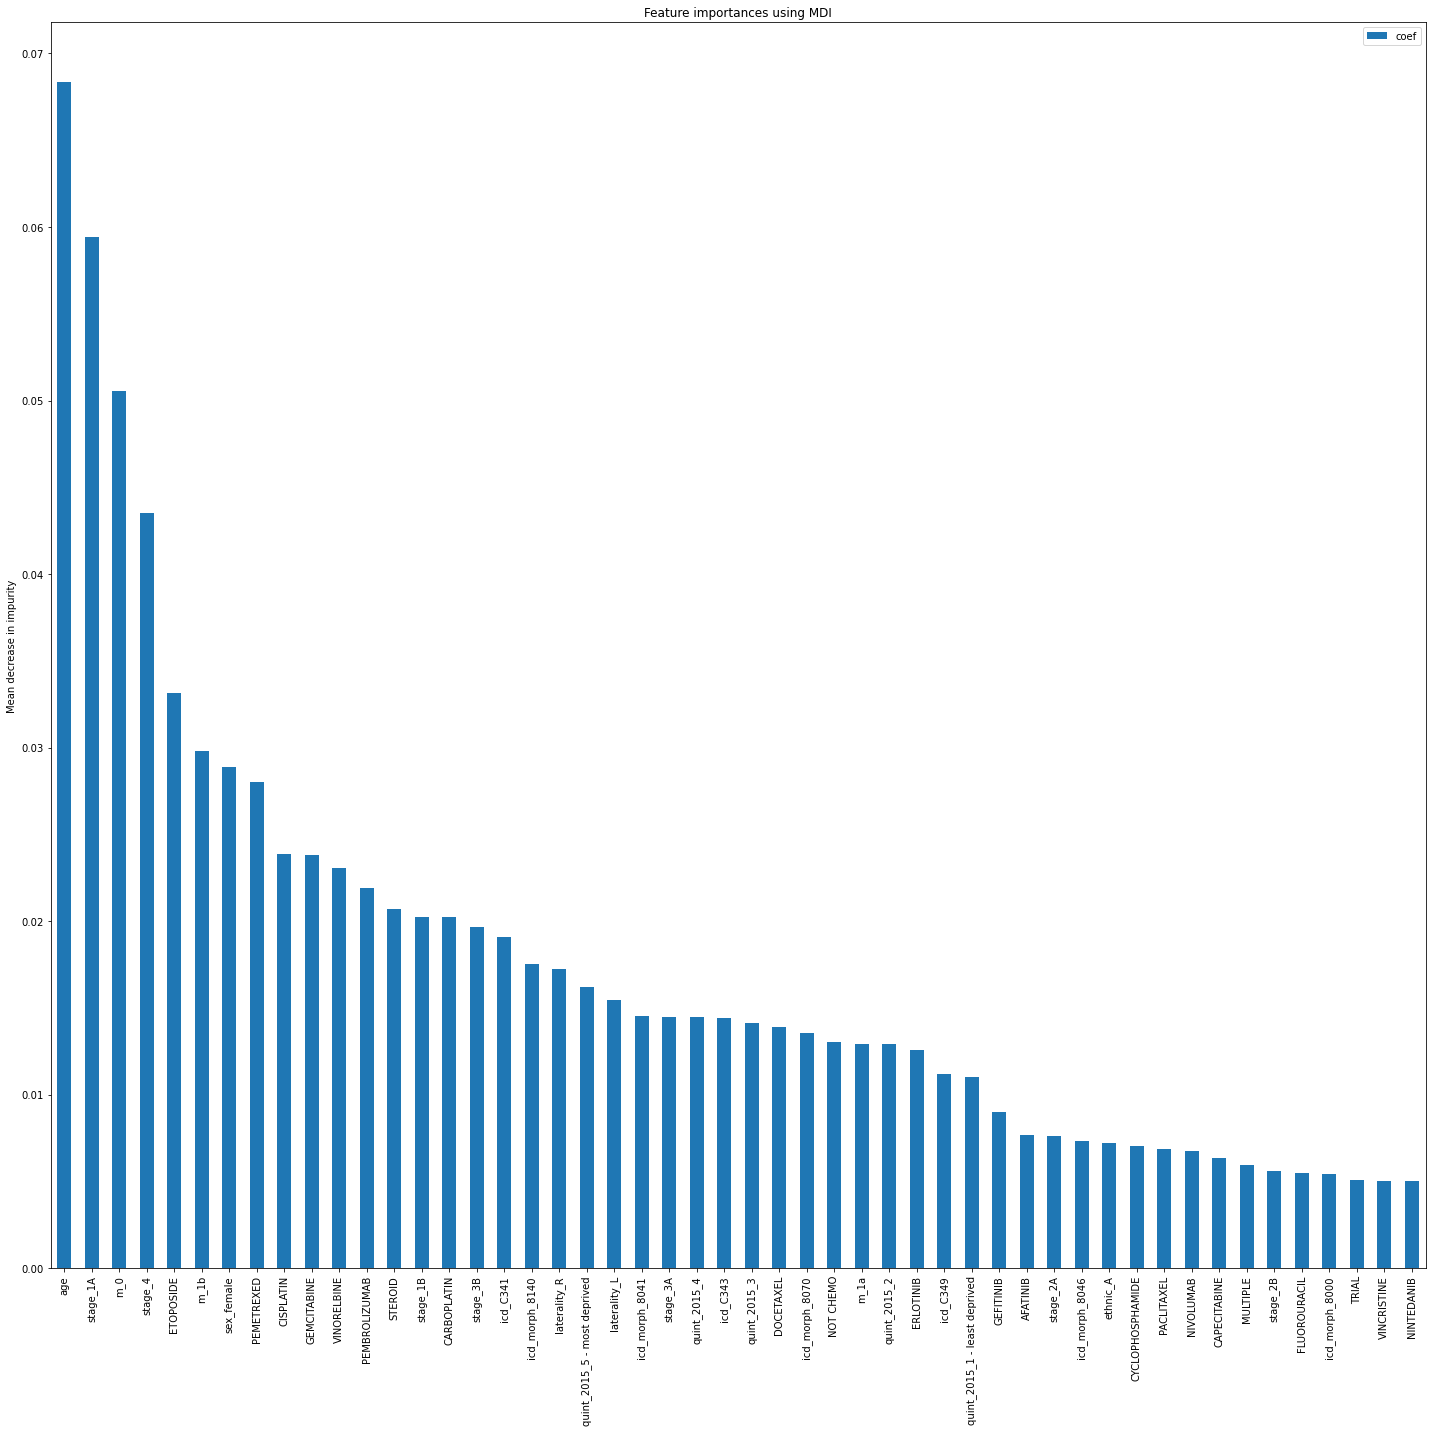

In [58]:
#create a bar plot of the top 50 features of importance 
fig, ax = plt.subplots()
feat_20.plot.bar(ax=ax, figsize=(20,20)) #yerr=std,
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- Plot above shows the top 50 important features 
- Age, stage 1a, no metastasis (m_0), stage 4, etoposide (drug) were the 5 top most important features
 - Sex female, and the drugs permetrexed, cisplatin, gemcitabine and pembrolizumab were also important features

#### Model Interpretation

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


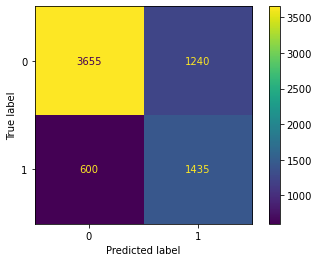

In [33]:
plot_confusion_matrix(forest, X_test, y_test)

- True Negatives (yellow square) = Actual not survived and predicted not survived
- True Positives (bottom blue square) = Actual survived and predicted survived
- False Negatives (bottom purple square) = Actual survived but predicted not survived
- False Positive (top blue square) = Actual not survived but predicted survived

- The confusion matrix is showing that the number of FP (1240) are quite high 

In [35]:
predictions = forest.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7344877344877345


- Accuracy = (TP + TN) / (TP+TN+FN+FP)

- The random forest model accurately predicted 73.4% of actual survived and not survived cases over all cases, which is lower than the logisitic regression model but still above the baseline 

In [36]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.8590    0.7467    0.7989      4895
           1     0.5364    0.7052    0.6093      2035

    accuracy                         0.7345      6930
   macro avg     0.6977    0.7259    0.7041      6930
weighted avg     0.7643    0.7345    0.7432      6930



- Precision score for  survived class (1) = 0.53; low
- We want to have the least amount of false positives -  predicting a patient will survive but the patient does not survive
- Therefore want higher precision = (TP / (TP + FP) 
 - reducing FP will increase precision 

In [39]:
results = []
for cutoff in np.arange(0, 1.1, 0.1):
    pred = pd.DataFrame(np.where(forest.predict_proba(X_test)[:,1] > cutoff, 1, 0 ))
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    results.append((cutoff, precision, recall, f1))
pd.DataFrame(results, columns=["CUTOFF", "PRECISION", "RECALL", "F1"]).sort_values("PRECISION", ascending=False)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,CUTOFF,PRECISION,RECALL,F1
8,0.8,0.933333,0.013759,0.027119
7,0.7,0.785000,0.077150,0.140492
6,0.6,0.657758,0.435381,0.523950
5,0.5,0.536449,0.705160,0.609342
4,0.4,0.444812,0.859459,0.586224
3,0.3,0.416935,0.890418,0.567936
2,0.2,0.297143,0.996560,0.457788
0,0.0,0.293651,1.000000,0.453988
1,0.1,0.293651,1.000000,0.453988
9,0.9,0.000000,0.000000,0.000000


- A good cutoff might be 0.6 as precision is 0.66 and recall is not very low (0.43)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


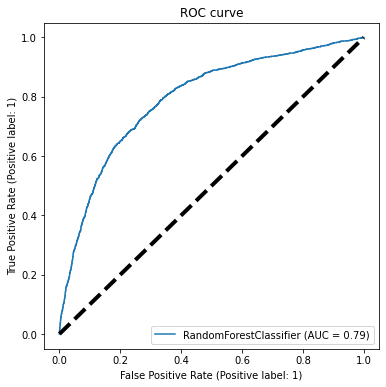

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(forest, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.title('ROC curve')
plt.show()

- The ROC curve indicates the forest model correctly classified 79% of predictions, which is lower than the logistic regression model (81%)
- A threshold of 0.6-0.8 appears to be the most optimal for reducing the FP rate

## Conclusions

The goal was to accurately classify whether lung cancer patients' survived or did not survive and acheive a score above the baseline accuracy (70%). Additionally, we wanted to reduce the rate of false positives ie. predicting a patient will survive when they did not. Therefore, we wanted to optimize the precision score, while maintaining a recall score >0.1. 

After applying different classification models to a unbalanced and balanced (using SMOTE) training dataset, the the XGBoost model had the highest scores for both the balanced and unbalanced (0.78, and 0.81, respectively), which were above the baseline accuracy.

Some key features of importance were early stage (survived) vs late stage (not survived), the drugs ifamurtide, trastuzumab, enzalutamide, and vinflunine (survived) and etoposide, carboplatin, capmatinib, and gemtuzumab ozogamycin (not survived), and mixed white and black african ethnicity (not survived). The accuracy score on the test data indicated that 77% of the predictions (TP and TN) were accurately predicted over all predictions. The classification report showed that the precision score for the survived class was 0.63. A threshold/cutoff value of 0.7 gave the optimal precision score (0.7) while not reducing the recall score too low (0.14).   



Limitations in using the logistic regression model: 
- The target variable did have a class imbalance (70:30); 
- There was an assumption that the features did not have multi-colinearity; 
- There may have been features included in the analysis that were not relevant, specifically the drug variables (high number and certain drugs may have been received by very few patients)
- The feature importances may not accurately represent what features impacted which class

Future work: 
 - Using a grid search to tune a decision tree model and visualize the tree to better determine the features involved in the decision and what class is impacted
 - Reducing non relevant drug columns or grouping the individual drugs under drug classes or mechanism of action
 - Explore different cancer types and determine if other predictors/ drugs are more/less important (started looking at breast cancer)
 